## Purpose

To compute the ML performance of the proposed method in near real-time.

In [1]:
import json
from sklearn.metrics import roc_auc_score, average_precision_score
import pandas as pd
from collections import defaultdict
from matplotlib import pyplot as plt
import seaborn as sns
import os
import numpy as np
import string

## All Attack Files by Correlation Method

In [2]:
files = []

for file in os.listdir("../data/"):
    if file.startswith("results_"):
        if file.endswith("_correlation_ROAD.json"):
            files.append(file)

print(len(files), files)
# files = [files[0], files[1], files[2], files[3]]
# print(files)

13 ['results_reverse_light_on_attack_3_masquerade_correlation_ROAD.json', 'results_max_engine_coolant_temp_attack_masquerade_correlation_ROAD.json', 'results_correlated_signal_attack_2_masquerade_correlation_ROAD.json', 'results_reverse_light_off_attack_3_masquerade_correlation_ROAD.json', 'results_max_speedometer_attack_3_masquerade_correlation_ROAD.json', 'results_reverse_light_off_attack_1_masquerade_correlation_ROAD.json', 'results_max_speedometer_attack_1_masquerade_correlation_ROAD.json', 'results_correlated_signal_attack_1_masquerade_correlation_ROAD.json', 'results_correlated_signal_attack_3_masquerade_correlation_ROAD.json', 'results_reverse_light_off_attack_2_masquerade_correlation_ROAD.json', 'results_reverse_light_on_attack_1_masquerade_correlation_ROAD.json', 'results_max_speedometer_attack_2_masquerade_correlation_ROAD.json', 'results_reverse_light_on_attack_2_masquerade_correlation_ROAD.json']


## Filtering Files Per Attacks File

In [3]:
# metrics = ["DR", "FAR", "AUC-ROC", "AUC-PR"]
# coordinates = [[0, 0], [0, 1], [1, 0], [1, 1]]

# fig, axes = plt.subplots(2, 2, figsize=(25, 14), sharex=True, sharey=True, gridspec_kw = {"wspace":-0.02, "hspace":0.1})
# fig.suptitle("Logistic Regression", size=12)

dfs_correlated = []
dfs_max_engine = []
dfs_max_speedometer = []
dfs_rev_light_off = []
dfs_rev_light_on = []

for index, file in enumerate(files):

    print(file)

    with open(f"/home/cloud/ceph-robust/CAN/signal-ids-benchmark/data/{file}", "r") as outfile:
        grid2performance = json.load(outfile)


    key2aucroc = defaultdict(list)
    index = []

    for key in grid2performance.keys():

        ground_truth = grid2performance[key]["ground_truth"]
        predict_proba = grid2performance[key]["predict_proba"]

        columns = key.split("-")

        # print(columns)
        key2aucroc[columns[0]].append(roc_auc_score(ground_truth, predict_proba))
        # sample.append(dict(entry))

        if columns[1] not in index: 
            index.append(columns[1])

    key2aucroc = dict(key2aucroc)
    # print(key2aucroc)
    # print(len(index), index)

    df_rocauc = pd.DataFrame({k:pd.Series(v) for k, v in key2aucroc.items()})
    df_rocauc.index = index
    df_rocauc = df_rocauc[::-1] # invert the order of dataframe rows


    if "correlated" in file:
        dfs_correlated.append(df_rocauc)

    if "max_engine" in file:
        dfs_max_engine.append(df_rocauc)

    if "speedometer" in file:
        dfs_max_speedometer.append(df_rocauc)

    if "reverse_light_off" in file:
        dfs_rev_light_off.append(df_rocauc)

    if "reverse_light_on" in file:
        dfs_rev_light_on.append(df_rocauc)

results_reverse_light_on_attack_3_masquerade_correlation_ROAD.json
results_max_engine_coolant_temp_attack_masquerade_correlation_ROAD.json
results_correlated_signal_attack_2_masquerade_correlation_ROAD.json
results_reverse_light_off_attack_3_masquerade_correlation_ROAD.json
results_max_speedometer_attack_3_masquerade_correlation_ROAD.json
results_reverse_light_off_attack_1_masquerade_correlation_ROAD.json
results_max_speedometer_attack_1_masquerade_correlation_ROAD.json
results_correlated_signal_attack_1_masquerade_correlation_ROAD.json
results_correlated_signal_attack_3_masquerade_correlation_ROAD.json
results_reverse_light_off_attack_2_masquerade_correlation_ROAD.json
results_reverse_light_on_attack_1_masquerade_correlation_ROAD.json
results_max_speedometer_attack_2_masquerade_correlation_ROAD.json
results_reverse_light_on_attack_2_masquerade_correlation_ROAD.json


## Average Correlated Attack

In [4]:
method = "correlation"
attack = "correlated"

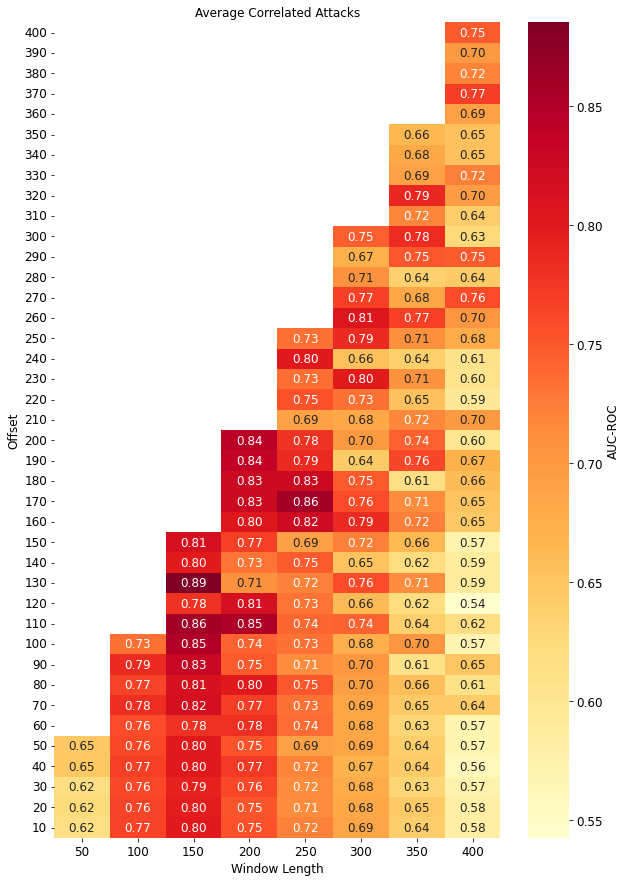

mean:  0.7125660209700274
std:  0.07317788086856296
median:  0.7162135829286991
min:  0.542492595124174 ('120', '400')
max:  0.8852668845315904 ('130', '150') 



In [5]:
df_to_inspect = dfs_correlated
df_rocauc_avg = pd.DataFrame(np.array([df.to_numpy() for df in df_to_inspect]).mean(axis=0), index=df_to_inspect[0].index, columns=df_to_inspect[0].columns)
df_rocauc_avg.to_csv(f"../data/average_{method}_method_{attack}_attack.csv", sep=" ", header=True)

fig, ax = plt.subplots(figsize=(10, 15))

g = sns.heatmap(df_rocauc_avg, annot=True, cbar=True, cbar_kws={"label": "AUC-ROC", "location":"right", "pad":0.05, "format":"%.2f"}, 
    annot_kws={"size": 12}, fmt=".2f", ax=ax, cmap="YlOrRd")

ax.set_ylabel("Offset", fontsize=12)
ax.set_xlabel("Window Length", fontsize=12)
ax.set_title("Average Correlated Attacks", fontsize=12)

# colobar
cax = g.figure.axes[-1]
cax.yaxis.label.set_size(12)
cax.tick_params(labelsize=12)

# x-axis
g.set_xticklabels(g.get_xticklabels(), rotation=0, fontsize=12)

# y-axis
if g.get_yticklabels():
    g.set_yticklabels(g.get_yticklabels(), rotation=0, fontsize=12)

plt.show()

# Compute basic statistics about elements in the frame
print("mean: ", np.nanmean(df_rocauc_avg))
print("std: ", np.nanstd(df_rocauc_avg))
print("median: ", np.nanmedian(df_rocauc_avg))
print("min: ", np.nanmin(df_rocauc_avg), df_rocauc_avg.stack().idxmin())
print("max: ", np.nanmax(df_rocauc_avg), df_rocauc_avg.stack().idxmax(), "\n")

## Average Max Engine Attack

In [6]:
method = "correlation"
attack = "max_engine"

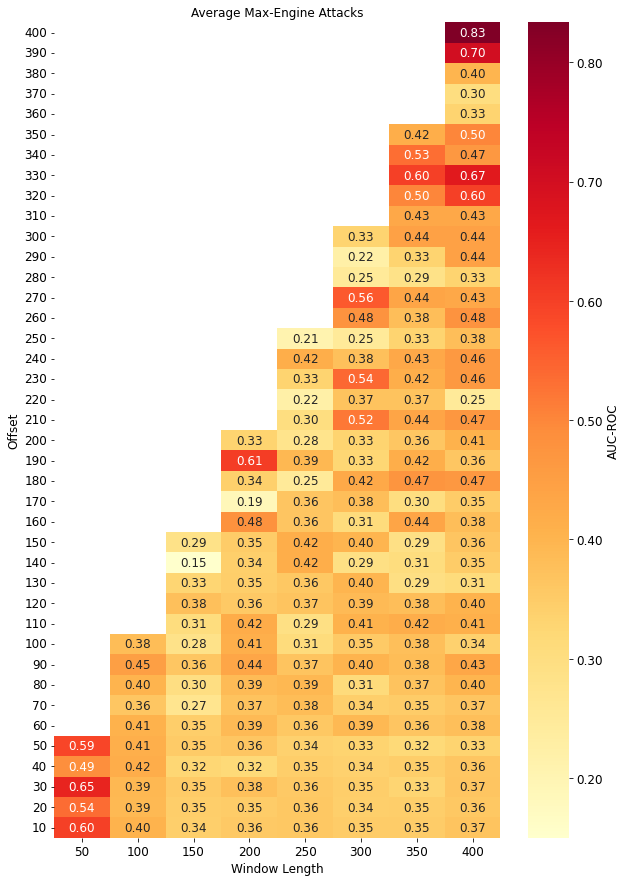

mean:  0.38445465628053493
std:  0.09000761384083839
median:  0.3669911202185792
min:  0.14999999999999997 ('140', '150')
max:  0.8333333333333334 ('400', '400') 



In [7]:
df_to_inspect = dfs_max_engine
df_rocauc_avg = pd.DataFrame(np.array([df.to_numpy() for df in df_to_inspect]).mean(axis=0), index=df_to_inspect[0].index, columns=df_to_inspect[0].columns)
# display(df_rocauc_avg)
df_rocauc_avg.to_csv(f"../data/average_{method}_method_{attack}_attack.csv", sep=" ", header=True)

fig, ax = plt.subplots(figsize=(10, 15))

g = sns.heatmap(df_rocauc_avg, annot=True, cbar=True, cbar_kws={"label": "AUC-ROC", "location":"right", "pad":0.05, "format":"%.2f"}, 
    annot_kws={"size": 12}, fmt=".2f", ax=ax, cmap="YlOrRd")

ax.set_ylabel("Offset", fontsize=12)
ax.set_xlabel("Window Length", fontsize=12)
ax.set_title("Average Max-Engine Attacks", fontsize=12)

# colobar
cax = g.figure.axes[-1]
cax.yaxis.label.set_size(12)
cax.tick_params(labelsize=12)

# x-axis
g.set_xticklabels(g.get_xticklabels(), rotation=0, fontsize=12)

# y-axis
if g.get_yticklabels():
    g.set_yticklabels(g.get_yticklabels(), rotation=0, fontsize=12)


plt.show()

# Compute basic statistics about elements in the frame
print("mean: ", np.nanmean(df_rocauc_avg))
print("std: ", np.nanstd(df_rocauc_avg))
print("median: ", np.nanmedian(df_rocauc_avg))
print("min: ", np.nanmin(df_rocauc_avg), df_rocauc_avg.stack().idxmin())
print("max: ", np.nanmax(df_rocauc_avg), df_rocauc_avg.stack().idxmax(), "\n")

## Average Max Speedometer Attack

In [8]:
method = "correlation"
attack = "max_speedometer"

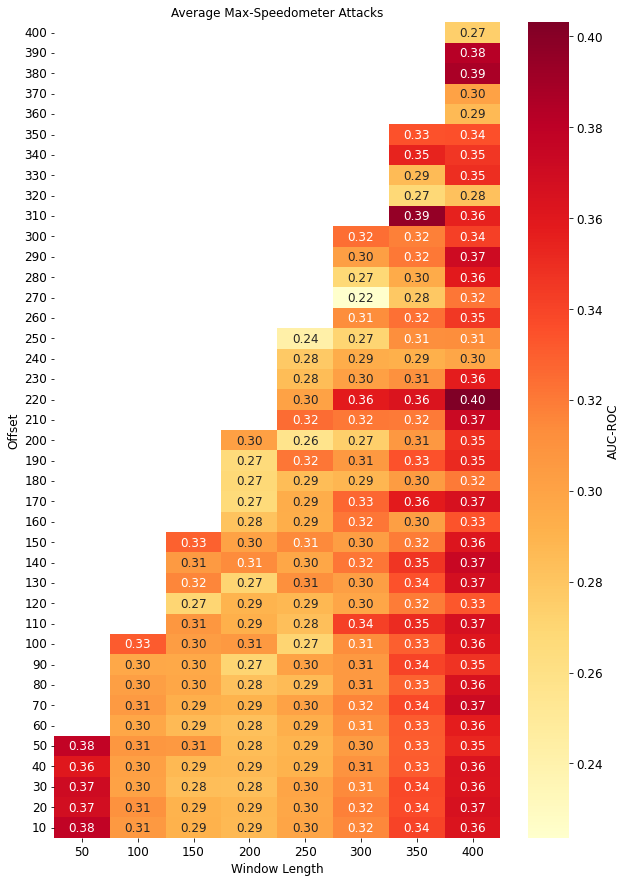

mean:  0.3159600500030014
std:  0.0322263392552207
median:  0.30978729272043337
min:  0.2236601428630414 ('270', '300')
max:  0.40295260295260293 ('220', '400') 



In [9]:
df_to_inspect = dfs_max_speedometer
df_rocauc_avg = pd.DataFrame(np.array([df.to_numpy() for df in df_to_inspect]).mean(axis=0), index=df_to_inspect[0].index, columns=df_to_inspect[0].columns)
df_rocauc_avg.to_csv(f"../data/average_{method}_method_{attack}_attack.csv", sep=" ", header=True)

fig, ax = plt.subplots(figsize=(10, 15))

g = sns.heatmap(df_rocauc_avg, annot=True, cbar=True, cbar_kws={"label": "AUC-ROC", "location":"right", "pad":0.05, "format":"%.2f"}, 
    annot_kws={"size": 12}, fmt=".2f", ax=ax, cmap="YlOrRd")

ax.set_ylabel("Offset", fontsize=12)
ax.set_xlabel("Window Length", fontsize=12)
ax.set_title("Average Max-Speedometer Attacks", fontsize=12)

# colobar
cax = g.figure.axes[-1]
cax.yaxis.label.set_size(12)
cax.tick_params(labelsize=12)

# x-axis
g.set_xticklabels(g.get_xticklabels(), rotation=0, fontsize=12)

# y-axis
if g.get_yticklabels():
    g.set_yticklabels(g.get_yticklabels(), rotation=0, fontsize=12)

plt.show()

# Compute basic statistics about elements in the frame
print("mean: ", np.nanmean(df_rocauc_avg))
print("std: ", np.nanstd(df_rocauc_avg))
print("median: ", np.nanmedian(df_rocauc_avg))
print("min: ", np.nanmin(df_rocauc_avg), df_rocauc_avg.stack().idxmin())
print("max: ", np.nanmax(df_rocauc_avg), df_rocauc_avg.stack().idxmax(), "\n")

## Average Reverse Light Off Attack

In [10]:
method = "correlation"
attack = "light_off"

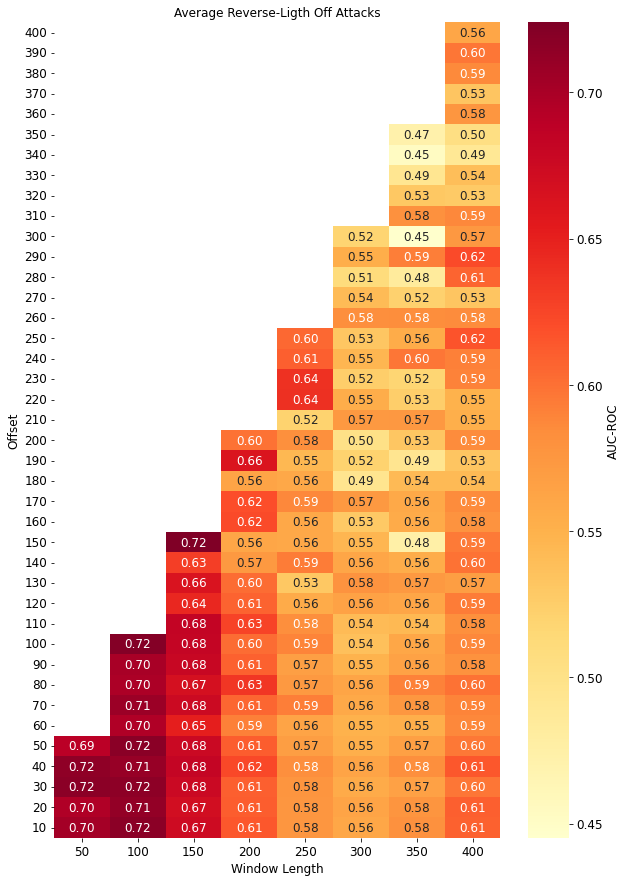

mean:  0.5876639319620477
std:  0.05792614223892665
median:  0.5799055091171167
min:  0.4451178451178451 ('300', '350')
max:  0.7239691027926322 ('150', '150') 



In [11]:
df_to_inspect = dfs_rev_light_off
df_rocauc_avg = pd.DataFrame(np.array([df.to_numpy() for df in df_to_inspect]).mean(axis=0), index=df_to_inspect[0].index, columns=df_to_inspect[0].columns)
df_rocauc_avg.to_csv(f"../data/average_{method}_method_{attack}_attack.csv", sep=" ", header=True)

fig, ax = plt.subplots(figsize=(10, 15))

g = sns.heatmap(df_rocauc_avg, annot=True, cbar=True, cbar_kws={"label": "AUC-ROC", "location":"right", "pad":0.05, "format":"%.2f"}, 
    annot_kws={"size": 12}, fmt=".2f", ax=ax, cmap="YlOrRd")

ax.set_ylabel("Offset", fontsize=12)
ax.set_xlabel("Window Length", fontsize=12)
ax.set_title("Average Reverse-Ligth Off Attacks", fontsize=12)

# colobar
cax = g.figure.axes[-1]
cax.yaxis.label.set_size(12)
cax.tick_params(labelsize=12)

# x-axis
g.set_xticklabels(g.get_xticklabels(), rotation=0, fontsize=12)

# y-axis
if g.get_yticklabels():
    g.set_yticklabels(g.get_yticklabels(), rotation=0, fontsize=12)

plt.show()

# Compute basic statistics about elements in the frame
print("mean: ", np.nanmean(df_rocauc_avg))
print("std: ", np.nanstd(df_rocauc_avg))
print("median: ", np.nanmedian(df_rocauc_avg))
print("min: ", np.nanmin(df_rocauc_avg), df_rocauc_avg.stack().idxmin())
print("max: ", np.nanmax(df_rocauc_avg), df_rocauc_avg.stack().idxmax(), "\n")

## Average Reverse Light On Attack

In [12]:
method = "correlation"
attack = "light_on"

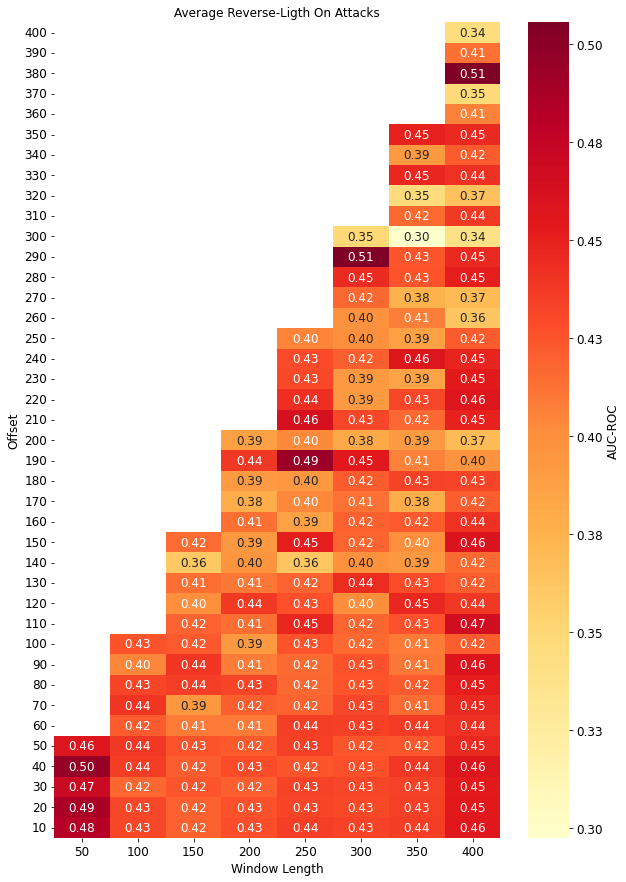

mean:  0.42175429314626806
std:  0.029928143097217478
median:  0.4240590440736389
min:  0.2975172975172975 ('300', '350')
max:  0.5055719921104537 ('290', '300') 



In [13]:
df_to_inspect = dfs_rev_light_on
df_rocauc_avg = pd.DataFrame(np.array([df.to_numpy() for df in df_to_inspect]).mean(axis=0), index=df_to_inspect[0].index, columns=df_to_inspect[0].columns)
df_rocauc_avg.to_csv(f"../data/average_{method}_method_{attack}_attack.csv", sep=" ", header=True)

fig, ax = plt.subplots(figsize=(10, 15))

g = sns.heatmap(df_rocauc_avg, annot=True, cbar=True, cbar_kws={"label": "AUC-ROC", "location":"right", "pad":0.05, "format":"%.2f"}, 
    annot_kws={"size": 12}, fmt=".2f", ax=ax, cmap="YlOrRd")

ax.set_ylabel("Offset", fontsize=12)
ax.set_xlabel("Window Length", fontsize=12)
ax.set_title("Average Reverse-Ligth On Attacks", fontsize=12)

# colobar
cax = g.figure.axes[-1]
cax.yaxis.label.set_size(12)
cax.tick_params(labelsize=12)

# x-axis
g.set_xticklabels(g.get_xticklabels(), rotation=0, fontsize=12)

# y-axis
if g.get_yticklabels():
    g.set_yticklabels(g.get_yticklabels(), rotation=0, fontsize=12)


plt.show()

# Compute basic statistics about elements in the frame
print("mean: ", np.nanmean(df_rocauc_avg))
print("std: ", np.nanstd(df_rocauc_avg))
print("median: ", np.nanmedian(df_rocauc_avg))
print("min: ", np.nanmin(df_rocauc_avg), df_rocauc_avg.stack().idxmin())
print("max: ", np.nanmax(df_rocauc_avg), df_rocauc_avg.stack().idxmax(), "\n")

## Single Figure Correlation

In [14]:
files = []

for file in os.listdir("../data/"):
    if file.startswith("average_correlation_"):
        # if file.endswith("_distribution_ROAD.json"):
        files.append(file)
        # print(file)

files = sorted(files)
# print(files)
files = [files[0], files[3], files[4], files[1], files[2]]
print(files)

['average_correlation_method_correlated_attack.csv', 'average_correlation_method_max_engine_attack.csv', 'average_correlation_method_max_speedometer_attack.csv', 'average_correlation_method_light_off_attack.csv', 'average_correlation_method_light_on_attack.csv']


0 average_correlation_method_correlated_attack.csv
1 average_correlation_method_max_engine_attack.csv
2 average_correlation_method_max_speedometer_attack.csv


3 average_correlation_method_light_off_attack.csv
4 average_correlation_method_light_on_attack.csv


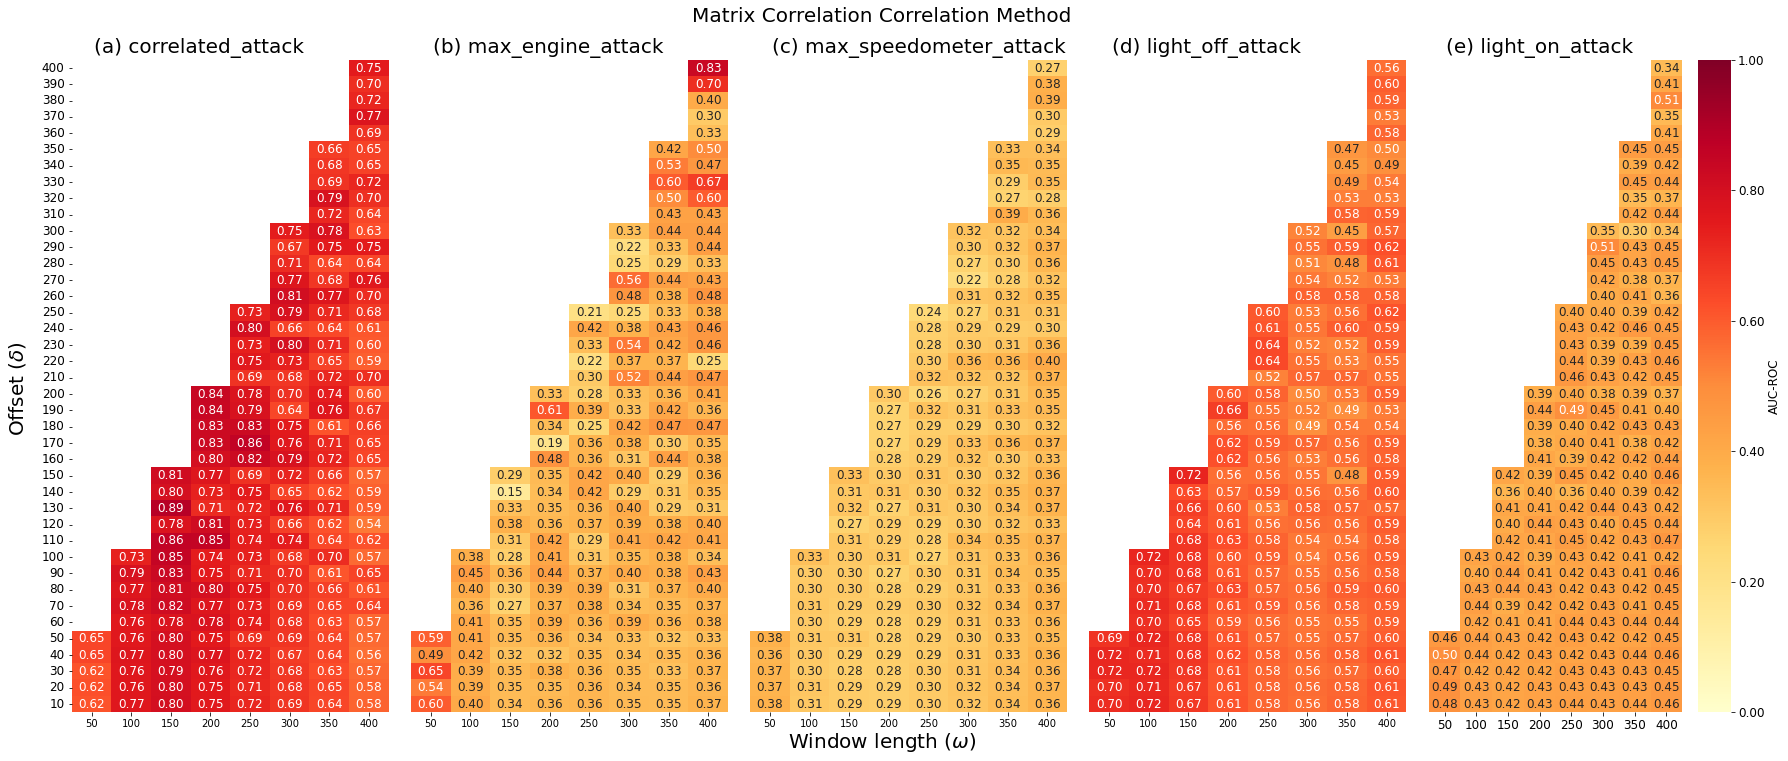

In [33]:
metrics = ["", "", "", "", ""]
coordinates = [[0, 0], [0, 1], [0, 2], [0, 3], [0, 4]]

fig, axes = plt.subplots(1, 5, figsize=(30, 12), sharex=True, sharey=True, gridspec_kw = {"wspace":0.07, "hspace":0.1}) # figsize=(30, 14)

# Set common labels
# axes.set_xlabel('common xlabel')
# axes.set_ylabel('common ylabel')
# fig.suptitle("Correlation Method", size=12)

for index, file in enumerate(files):

    print(index, file)

    df = pd.read_csv("../data/" + file, sep=" ", index_col=0)
    # display(df)
    # display(f"mean: {df.stack().dropna().mean()}, std: {df.stack().dropna().std()}, median: {df.stack().dropna().median()}")
    ax = index

    if index == 4:
        g = sns.heatmap(df, vmin=0.0, vmax=1.0, annot=True, cbar=True, cbar_kws={"label": "AUC-ROC", "location":"right", "pad":0.05, "format":"%.2f"}, 
            annot_kws={"size": 12}, fmt=".2f", ax=axes[index], cmap="YlOrRd")
        
        # g = sns.heatmap(df, vmin=0.0, vmax=1.0, annot=True, cbar=True, cbar_kws={"label": metrics[index], "location":"top", "pad":0.05, "format":"%.2f"}, annot_kws={"size": 12}, fmt=".2f", ax=axes[index], cmap="YlOrRd")
        
    else:
        g = sns.heatmap(df, vmin=0.0, vmax=1.0, annot=True, cbar=False, annot_kws={"size": 12}, fmt=".2f", ax=axes[index], cmap="YlOrRd")

    # text annotation
    annotation = file.split("method")
    axes[index].text(0.07, 1.01, "(" + string.ascii_lowercase[index] + ")" + " " + annotation[1][1:-4], transform=axes[index].transAxes, size=20)
    
    # print(annotation)
    # print(annotation[1][1:-4])

    # colobar
    cax = g.figure.axes[-1]
    cax.yaxis.label.set_size(12)
    cax.tick_params(labelsize=12)

    # # x-axis
    # g.set_xticklabels(g.get_xticklabels(), rotation=90, fontsize=12)

    # # y-axis
    if g.get_yticklabels():
        g.set_yticklabels(g.get_yticklabels(), fontsize=12)

    if index > 0:
        axes[index].tick_params(left=False)


# Set common labels
fig.text(0.5, 0.09, "Window length ($\omega$)", ha="center", va="center", fontsize=20)
fig.text(0.1, 0.50, "Offset ($\delta$)", ha="center", va="center", rotation="vertical", fontsize=20) # 0.1, 0.45
fig.text(0.5, 0.93, "Matrix Correlation Correlation Method", ha="center", va="center", fontsize=20)


plt.savefig("../figs/" + "correlation_all_fig.pdf", dpi=200, bbox_inches="tight")
plt.show()

## All Attack Files by Distribution Method

In [34]:
files = []

for file in os.listdir("../data/"):
    if file.startswith("results_"):
        if file.endswith("_distribution_ROAD.json"):
            files.append(file)

print(len(files), files)
# files = [files[0], files[1], files[2], files[3]]
# print(files)

13 ['results_max_speedometer_attack_3_masquerade_distribution_ROAD.json', 'results_correlated_signal_attack_2_masquerade_distribution_ROAD.json', 'results_max_engine_coolant_temp_attack_masquerade_distribution_ROAD.json', 'results_reverse_light_on_attack_3_masquerade_distribution_ROAD.json', 'results_reverse_light_on_attack_1_masquerade_distribution_ROAD.json', 'results_reverse_light_off_attack_1_masquerade_distribution_ROAD.json', 'results_correlated_signal_attack_3_masquerade_distribution_ROAD.json', 'results_max_speedometer_attack_2_masquerade_distribution_ROAD.json', 'results_reverse_light_off_attack_3_masquerade_distribution_ROAD.json', 'results_reverse_light_off_attack_2_masquerade_distribution_ROAD.json', 'results_reverse_light_on_attack_2_masquerade_distribution_ROAD.json', 'results_correlated_signal_attack_1_masquerade_distribution_ROAD.json', 'results_max_speedometer_attack_1_masquerade_distribution_ROAD.json']


## Filtering Files Per Attacks File

In [35]:
# metrics = ["DR", "FAR", "AUC-ROC", "AUC-PR"]
# coordinates = [[0, 0], [0, 1], [1, 0], [1, 1]]

# fig, axes = plt.subplots(2, 2, figsize=(25, 14), sharex=True, sharey=True, gridspec_kw = {"wspace":-0.02, "hspace":0.1})
# fig.suptitle("Logistic Regression", size=12)

dfs_correlated = []
dfs_max_engine = []
dfs_max_speedometer = []
dfs_rev_light_off = []
dfs_rev_light_on = []

for index, file in enumerate(files):

    print(file)

    with open(f"/home/cloud/ceph-robust/CAN/signal-ids-benchmark/data/{file}", "r") as outfile:
        grid2performance = json.load(outfile)

    key2aucroc = defaultdict(list)
    index = []

    for key in grid2performance.keys():

        ground_truth = grid2performance[key]["ground_truth"]
        predict_proba = grid2performance[key]["predict_proba"]

        columns = key.split("-")

        # print(columns)
        key2aucroc[columns[0]].append(roc_auc_score(ground_truth, predict_proba))
        # sample.append(dict(entry))

        if columns[1] not in index: 
            index.append(columns[1])

    key2aucroc = dict(key2aucroc)
    # print(key2aucroc)
    # print(len(index), index)

    df_rocauc = pd.DataFrame({k:pd.Series(v) for k, v in key2aucroc.items()})
    df_rocauc.index = index
    df_rocauc = df_rocauc[::-1] # invert the order of dataframe rows


    if "correlated" in file:
        dfs_correlated.append(df_rocauc)

    if "max_engine" in file:
        dfs_max_engine.append(df_rocauc)

    if "speedometer" in file:
        dfs_max_speedometer.append(df_rocauc)

    if "reverse_light_off" in file:
        dfs_rev_light_off.append(df_rocauc)

    if "reverse_light_on" in file:
        dfs_rev_light_on.append(df_rocauc)

results_max_speedometer_attack_3_masquerade_distribution_ROAD.json
results_correlated_signal_attack_2_masquerade_distribution_ROAD.json
results_max_engine_coolant_temp_attack_masquerade_distribution_ROAD.json
results_reverse_light_on_attack_3_masquerade_distribution_ROAD.json
results_reverse_light_on_attack_1_masquerade_distribution_ROAD.json
results_reverse_light_off_attack_1_masquerade_distribution_ROAD.json
results_correlated_signal_attack_3_masquerade_distribution_ROAD.json
results_max_speedometer_attack_2_masquerade_distribution_ROAD.json
results_reverse_light_off_attack_3_masquerade_distribution_ROAD.json
results_reverse_light_off_attack_2_masquerade_distribution_ROAD.json
results_reverse_light_on_attack_2_masquerade_distribution_ROAD.json
results_correlated_signal_attack_1_masquerade_distribution_ROAD.json
results_max_speedometer_attack_1_masquerade_distribution_ROAD.json


## Average Correlated Attack

In [36]:
method = "distribution"
attack = "correlated"

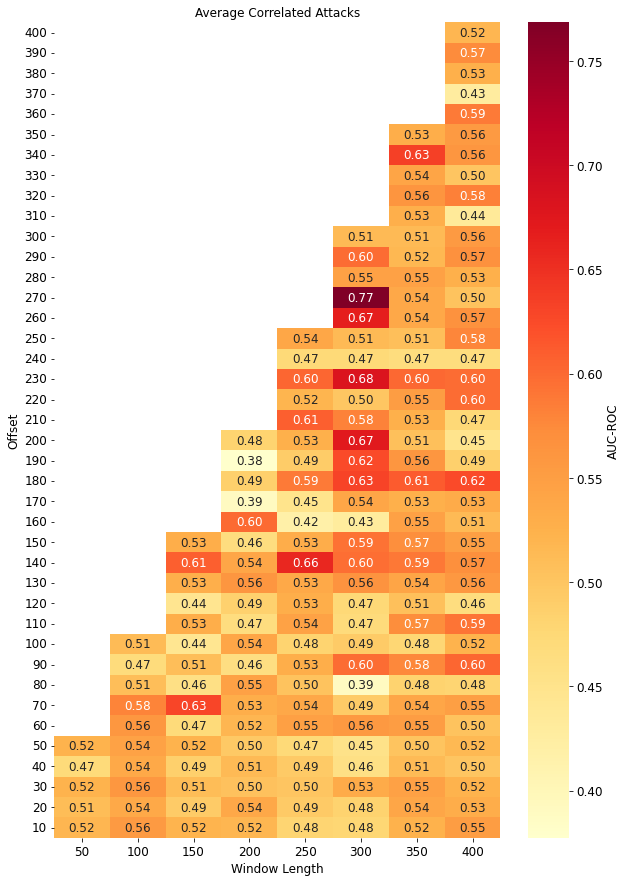

mean:  0.5292477970977397
std:  0.0556424631349114
median:  0.527281746031746
min:  0.3773148148148147 ('190', '200')
max:  0.7685185185185185 ('270', '300') 



In [37]:
df_to_inspect = dfs_correlated
df_rocauc_avg = pd.DataFrame(np.array([df.to_numpy() for df in df_to_inspect]).mean(axis=0), index=df_to_inspect[0].index, columns=df_to_inspect[0].columns)
df_rocauc_avg.to_csv(f"../data/average_{method}_method_{attack}_attack.csv", sep=" ", header=True)

fig, ax = plt.subplots(figsize=(10, 15))

g = sns.heatmap(df_rocauc_avg, annot=True, cbar=True, cbar_kws={"label": "AUC-ROC", "location":"right", "pad":0.05, "format":"%.2f"}, 
    annot_kws={"size": 12}, fmt=".2f", ax=ax, cmap="YlOrRd")

ax.set_ylabel("Offset", fontsize=12)
ax.set_xlabel("Window Length", fontsize=12)
ax.set_title("Average Correlated Attacks", fontsize=12)

# colobar
cax = g.figure.axes[-1]
cax.yaxis.label.set_size(12)
cax.tick_params(labelsize=12)

# x-axis
g.set_xticklabels(g.get_xticklabels(), rotation=0, fontsize=12)

# y-axis
if g.get_yticklabels():
    g.set_yticklabels(g.get_yticklabels(), rotation=0, fontsize=12)


plt.show()

# Compute basic statistics about elements in the frame
print("mean: ", np.nanmean(df_rocauc_avg))
print("std: ", np.nanstd(df_rocauc_avg))
print("median: ", np.nanmedian(df_rocauc_avg))
print("min: ", np.nanmin(df_rocauc_avg), df_rocauc_avg.stack().idxmin())
print("max: ", np.nanmax(df_rocauc_avg), df_rocauc_avg.stack().idxmax(), "\n")

## Average Max Engine Attack

In [38]:
method = "distribution"
attack = "max_engine"

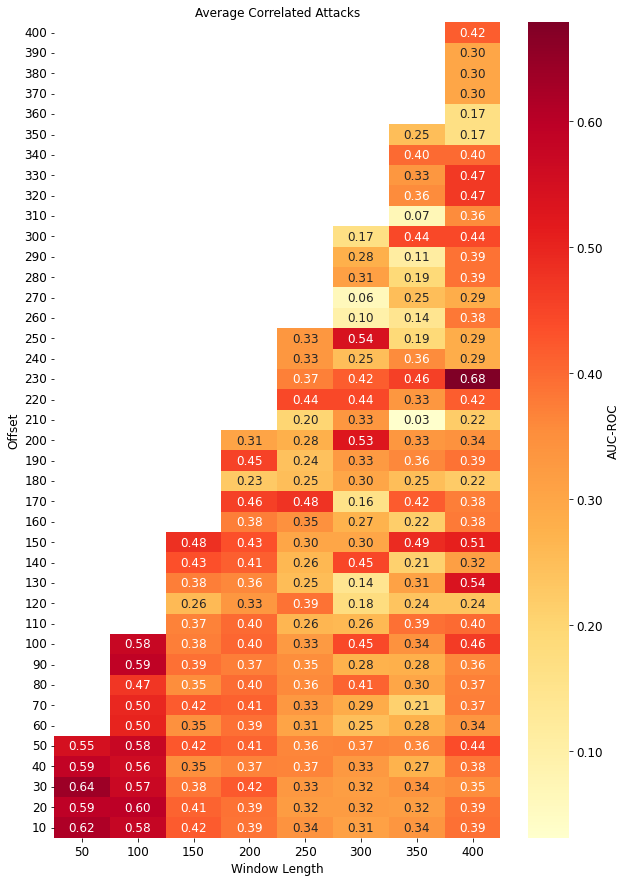

mean:  0.35639544214373287
std:  0.11339087431121432
median:  0.3578643578643579
min:  0.03125 ('210', '350')
max:  0.6785714285714285 ('230', '400') 



In [39]:
df_to_inspect = dfs_max_engine
df_rocauc_avg = pd.DataFrame(np.array([df.to_numpy() for df in df_to_inspect]).mean(axis=0), index=df_to_inspect[0].index, columns=df_to_inspect[0].columns)
df_rocauc_avg.to_csv(f"../data/average_{method}_method_{attack}_attack.csv", sep=" ", header=True)

fig, ax = plt.subplots(figsize=(10, 15))

g = sns.heatmap(df_rocauc_avg, annot=True, cbar=True, cbar_kws={"label": "AUC-ROC", "location":"right", "pad":0.05, "format":"%.2f"}, 
    annot_kws={"size": 12}, fmt=".2f", ax=ax, cmap="YlOrRd")

ax.set_ylabel("Offset", fontsize=12)
ax.set_xlabel("Window Length", fontsize=12)
ax.set_title("Average Correlated Attacks", fontsize=12)

# colobar
cax = g.figure.axes[-1]
cax.yaxis.label.set_size(12)
cax.tick_params(labelsize=12)

# x-axis
g.set_xticklabels(g.get_xticklabels(), rotation=0, fontsize=12)

# y-axis
if g.get_yticklabels():
    g.set_yticklabels(g.get_yticklabels(), rotation=0, fontsize=12)


plt.show()

# Compute basic statistics about elements in the frame
print("mean: ", np.nanmean(df_rocauc_avg))
print("std: ", np.nanstd(df_rocauc_avg))
print("median: ", np.nanmedian(df_rocauc_avg))
print("min: ", np.nanmin(df_rocauc_avg), df_rocauc_avg.stack().idxmin())
print("max: ", np.nanmax(df_rocauc_avg), df_rocauc_avg.stack().idxmax(), "\n")

## Average Max Speedometer Attack

In [40]:
method = "distribution"
attack = "max_speedometer"

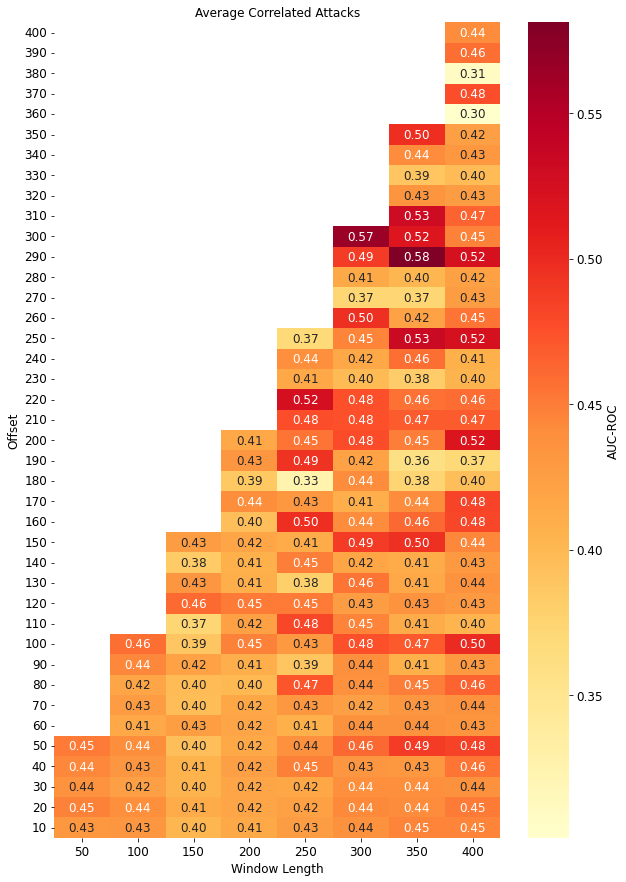

mean:  0.4360109334520762
std:  0.039899631270572125
median:  0.4336553097224033
min:  0.3009181450357921 ('360', '400')
max:  0.581158810325477 ('290', '350') 



In [41]:
df_to_inspect = dfs_max_speedometer
df_rocauc_avg = pd.DataFrame(np.array([df.to_numpy() for df in df_to_inspect]).mean(axis=0), index=df_to_inspect[0].index, columns=df_to_inspect[0].columns)
df_rocauc_avg.to_csv(f"../data/average_{method}_method_{attack}_attack.csv", sep=" ", header=True)

fig, ax = plt.subplots(figsize=(10, 15))

g = sns.heatmap(df_rocauc_avg, annot=True, cbar=True, cbar_kws={"label": "AUC-ROC", "location":"right", "pad":0.05, "format":"%.2f"}, 
    annot_kws={"size": 12}, fmt=".2f", ax=ax, cmap="YlOrRd")

ax.set_ylabel("Offset", fontsize=12)
ax.set_xlabel("Window Length", fontsize=12)
ax.set_title("Average Correlated Attacks", fontsize=12)

# colobar
cax = g.figure.axes[-1]
cax.yaxis.label.set_size(12)
cax.tick_params(labelsize=12)

# x-axis
g.set_xticklabels(g.get_xticklabels(), rotation=0, fontsize=12)

# y-axis
if g.get_yticklabels():
    g.set_yticklabels(g.get_yticklabels(), rotation=0, fontsize=12)

plt.show()

# Compute basic statistics about elements in the frame
print("mean: ", np.nanmean(df_rocauc_avg))
print("std: ", np.nanstd(df_rocauc_avg))
print("median: ", np.nanmedian(df_rocauc_avg))
print("min: ", np.nanmin(df_rocauc_avg), df_rocauc_avg.stack().idxmin())
print("max: ", np.nanmax(df_rocauc_avg), df_rocauc_avg.stack().idxmax(), "\n")

## Average Reverse Light Off Attack

In [42]:
method = "distribution"
attack = "light_off"

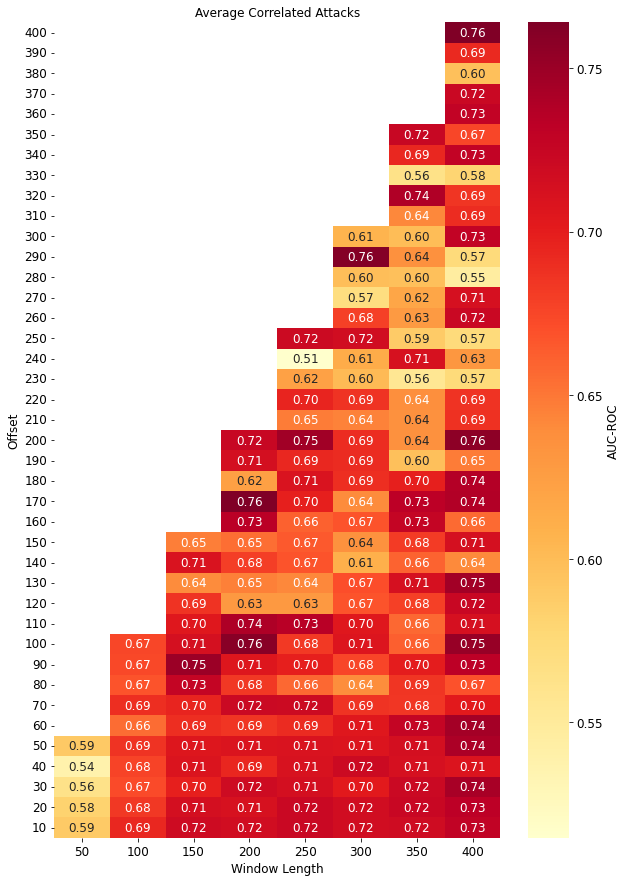

mean:  0.6799721480293047
std:  0.05125589704847243
median:  0.6906301951861231
min:  0.5147630147630148 ('240', '250')
max:  0.7638888888888888 ('400', '400') 



In [43]:
df_to_inspect = dfs_rev_light_off
df_rocauc_avg = pd.DataFrame(np.array([df.to_numpy() for df in df_to_inspect]).mean(axis=0), index=df_to_inspect[0].index, columns=df_to_inspect[0].columns)
df_rocauc_avg.to_csv(f"../data/average_{method}_method_{attack}_attack.csv", sep=" ", header=True)

fig, ax = plt.subplots(figsize=(10, 15))

g = sns.heatmap(df_rocauc_avg, annot=True, cbar=True, cbar_kws={"label": "AUC-ROC", "location":"right", "pad":0.05, "format":"%.2f"}, 
    annot_kws={"size": 12}, fmt=".2f", ax=ax, cmap="YlOrRd")

ax.set_ylabel("Offset", fontsize=12)
ax.set_xlabel("Window Length", fontsize=12)
ax.set_title("Average Correlated Attacks", fontsize=12)

# colobar
cax = g.figure.axes[-1]
cax.yaxis.label.set_size(12)
cax.tick_params(labelsize=12)

# x-axis
g.set_xticklabels(g.get_xticklabels(), rotation=0, fontsize=12)

# y-axis
if g.get_yticklabels():
    g.set_yticklabels(g.get_yticklabels(), rotation=0, fontsize=12)

plt.show()

# Compute basic statistics about elements in the frame
print("mean: ", np.nanmean(df_rocauc_avg))
print("std: ", np.nanstd(df_rocauc_avg))
print("median: ", np.nanmedian(df_rocauc_avg))
print("min: ", np.nanmin(df_rocauc_avg), df_rocauc_avg.stack().idxmin())
print("max: ", np.nanmax(df_rocauc_avg), df_rocauc_avg.stack().idxmax(), "\n")

## Average Reverse Light On Attack

In [44]:
method = "distribution"
attack = "light_on"

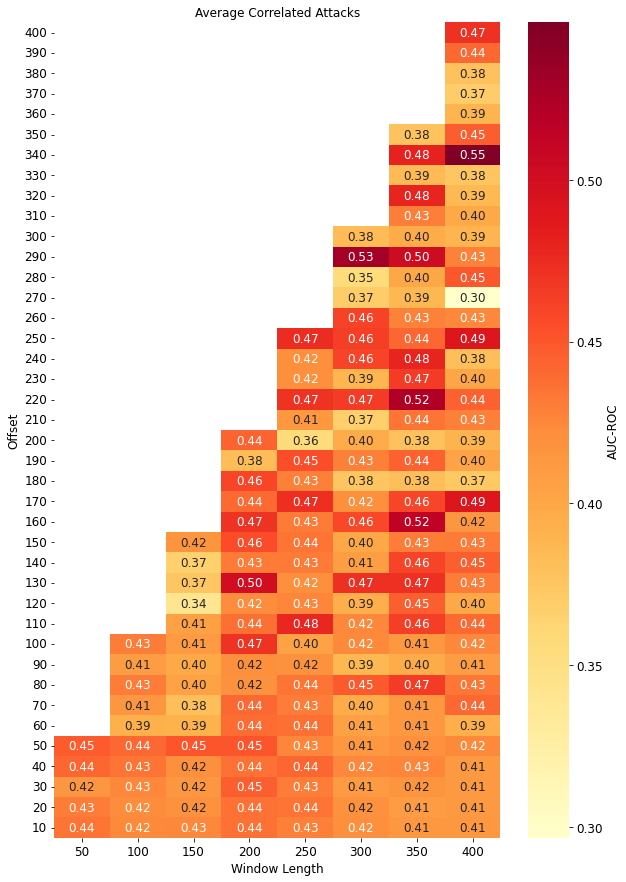

mean:  0.4259329749672769
std:  0.03496064433741226
median:  0.42520720051808425
min:  0.2967051467051467 ('270', '400')
max:  0.5486171236171237 ('340', '400') 



In [45]:
df_to_inspect = dfs_rev_light_on
df_rocauc_avg = pd.DataFrame(np.array([df.to_numpy() for df in df_to_inspect]).mean(axis=0), index=df_to_inspect[0].index, columns=df_to_inspect[0].columns)
df_rocauc_avg.to_csv(f"../data/average_{method}_method_{attack}_attack.csv", sep=" ", header=True)

fig, ax = plt.subplots(figsize=(10, 15))

g = sns.heatmap(df_rocauc_avg, annot=True, cbar=True, cbar_kws={"label": "AUC-ROC", "location":"right", "pad":0.05, "format":"%.2f"}, 
    annot_kws={"size": 12}, fmt=".2f", ax=ax, cmap="YlOrRd")

ax.set_ylabel("Offset", fontsize=12)
ax.set_xlabel("Window Length", fontsize=12)
ax.set_title("Average Correlated Attacks", fontsize=12)

# colobar
cax = g.figure.axes[-1]
cax.yaxis.label.set_size(12)
cax.tick_params(labelsize=12)

# x-axis
g.set_xticklabels(g.get_xticklabels(), rotation=0, fontsize=12)

# y-axis
if g.get_yticklabels():
    g.set_yticklabels(g.get_yticklabels(), rotation=0, fontsize=12)

plt.show()

# Compute basic statistics about elements in the frame
print("mean: ", np.nanmean(df_rocauc_avg))
print("std: ", np.nanstd(df_rocauc_avg))
print("median: ", np.nanmedian(df_rocauc_avg))
print("min: ", np.nanmin(df_rocauc_avg), df_rocauc_avg.stack().idxmin())
print("max: ", np.nanmax(df_rocauc_avg), df_rocauc_avg.stack().idxmax(), "\n")

## Single Figure Distribution

In [46]:
files = []

for file in os.listdir("../data/"):
    if file.startswith("average_distribution_"):
        # if file.endswith("_distribution_ROAD.json"):
        files.append(file)
        # print(file)

# files = sorted(files)
print(files)
files = [files[4], files[1], files[2], files[0], files[3]]
print(files)

['average_distribution_method_light_off_attack.csv', 'average_distribution_method_max_engine_attack.csv', 'average_distribution_method_max_speedometer_attack.csv', 'average_distribution_method_light_on_attack.csv', 'average_distribution_method_correlated_attack.csv']
['average_distribution_method_correlated_attack.csv', 'average_distribution_method_max_engine_attack.csv', 'average_distribution_method_max_speedometer_attack.csv', 'average_distribution_method_light_off_attack.csv', 'average_distribution_method_light_on_attack.csv']


0 average_distribution_method_correlated_attack.csv
1 average_distribution_method_max_engine_attack.csv
2 average_distribution_method_max_speedometer_attack.csv
3 average_distribution_method_light_off_attack.csv
4 average_distribution_method_light_on_attack.csv


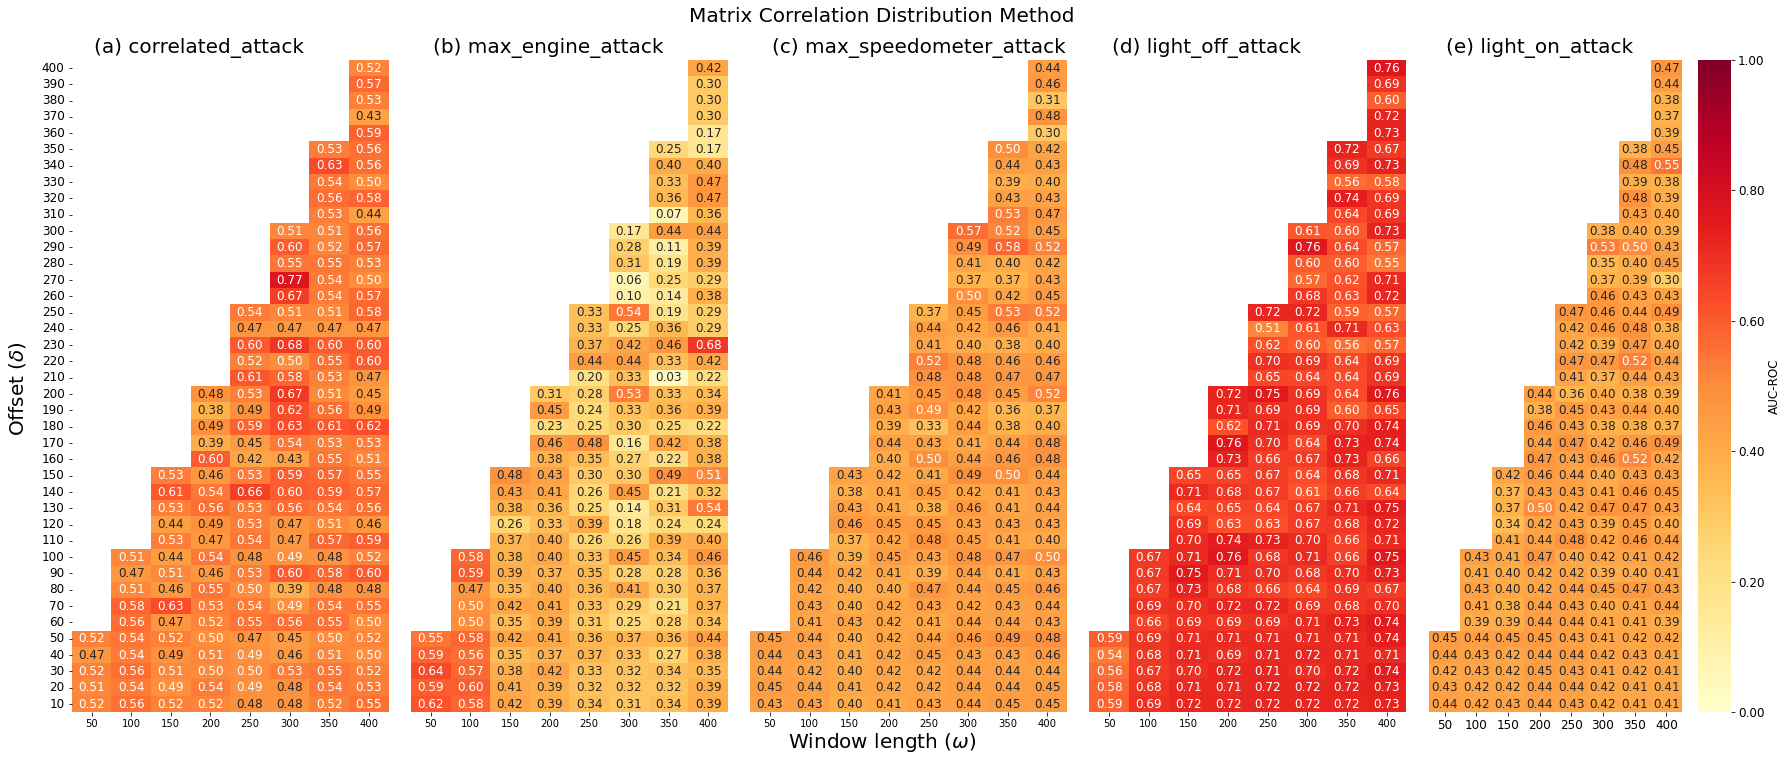

In [49]:
metrics = ["", "", "", "", ""]
coordinates = [[0, 0], [0, 1], [0, 2], [0, 3], [0, 4]]

fig, axes = plt.subplots(1, 5, figsize=(30, 12), sharex=True, sharey=True, gridspec_kw = {"wspace":0.07, "hspace":0.1}) # figsize=(30, 14)

# Set common labels
# axes.set_xlabel('common xlabel')
# axes.set_ylabel('common ylabel')
# fig.suptitle("Correlation Method", size=12)

for index, file in enumerate(files):

    print(index, file)

    df = pd.read_csv("../data/" + file, sep=" ", index_col=0)
    # display(df)
    # display(f"mean: {df.stack().dropna().mean()}, std: {df.stack().dropna().std()}, median: {df.stack().dropna().median()}")
    ax = index

    if index == 4:
        g = sns.heatmap(df, vmin=0.0, vmax=1.0, annot=True, cbar=True, cbar_kws={"label": "AUC-ROC", "location":"right", "pad":0.05, "format":"%.2f"}, 
            annot_kws={"size": 12}, fmt=".2f", ax=axes[index], cmap="YlOrRd")
        
        # g = sns.heatmap(df, vmin=0.0, vmax=1.0, annot=True, cbar=True, cbar_kws={"label": metrics[index], "location":"top", "pad":0.05, "format":"%.2f"}, annot_kws={"size": 12}, fmt=".2f", ax=axes[index], cmap="YlOrRd")
        
    else:
        g = sns.heatmap(df, vmin=0.0, vmax=1.0, annot=True, cbar=False, annot_kws={"size": 12}, fmt=".2f", ax=axes[index], cmap="YlOrRd")

    # text annotation
    annotation = file.split("method")
    axes[index].text(0.07, 1.01, "(" + string.ascii_lowercase[index] + ")" + " " + annotation[1][1:-4], transform=axes[index].transAxes, size=20)
    
    # print(annotation)
    # print(annotation[1][1:-4])

    # colobar
    cax = g.figure.axes[-1]
    cax.yaxis.label.set_size(12)
    cax.tick_params(labelsize=12)

    # # x-axis
    # g.set_xticklabels(g.get_xticklabels(), rotation=90, fontsize=12)

    # # y-axis
    if g.get_yticklabels():
        g.set_yticklabels(g.get_yticklabels(), fontsize=12)

    if index > 0:
        axes[index].tick_params(left=False)


# Set common labels
fig.text(0.5, 0.09, "Window length ($\omega$)", ha="center", va="center", fontsize=20)
fig.text(0.1, 0.50, "Offset ($\delta$)", ha="center", va="center", rotation="vertical", fontsize=20) # 0.1, 0.45
fig.text(0.5, 0.93, "Matrix Correlation Distribution Method", ha="center", va="center", fontsize=20)


plt.savefig("../figs/" + "distribution_all_fig.pdf", dpi=200, bbox_inches="tight")
plt.show()

## All Attack Files by DBSCAN Method

In [50]:
files = []

for file in os.listdir("../data/"):
    if file.startswith("results_"):
        if file.endswith("_DBSCAN_ROAD.json"):
            files.append(file)

print(len(files), files)
# files = [files[0], files[1], files[2], files[3]]
# print(files)

13 ['results_correlated_signal_attack_2_masquerade_DBSCAN_ROAD.json', 'results_reverse_light_on_attack_2_masquerade_DBSCAN_ROAD.json', 'results_max_engine_coolant_temp_attack_masquerade_DBSCAN_ROAD.json', 'results_max_speedometer_attack_1_masquerade_DBSCAN_ROAD.json', 'results_correlated_signal_attack_1_masquerade_DBSCAN_ROAD.json', 'results_reverse_light_on_attack_3_masquerade_DBSCAN_ROAD.json', 'results_reverse_light_off_attack_1_masquerade_DBSCAN_ROAD.json', 'results_reverse_light_off_attack_2_masquerade_DBSCAN_ROAD.json', 'results_correlated_signal_attack_3_masquerade_DBSCAN_ROAD.json', 'results_max_speedometer_attack_2_masquerade_DBSCAN_ROAD.json', 'results_reverse_light_off_attack_3_masquerade_DBSCAN_ROAD.json', 'results_max_speedometer_attack_3_masquerade_DBSCAN_ROAD.json', 'results_reverse_light_on_attack_1_masquerade_DBSCAN_ROAD.json']


## Filtering Files Per Attacks File

In [51]:
# metrics = ["DR", "FAR", "AUC-ROC", "AUC-PR"]
# coordinates = [[0, 0], [0, 1], [1, 0], [1, 1]]

# fig, axes = plt.subplots(2, 2, figsize=(25, 14), sharex=True, sharey=True, gridspec_kw = {"wspace":-0.02, "hspace":0.1})
# fig.suptitle("Logistic Regression", size=12)

dfs_correlated = []
dfs_max_engine = []
dfs_max_speedometer = []
dfs_rev_light_off = []
dfs_rev_light_on = []

for index, file in enumerate(files):

    print(file)

    with open(f"/home/cloud/ceph-robust/CAN/signal-ids-benchmark/data/{file}", "r") as outfile:
        grid2performance = json.load(outfile)


    key2aucroc = defaultdict(list)
    index = []

    for key in grid2performance.keys():

        ground_truth = grid2performance[key]["ground_truth"]
        predict_proba = grid2performance[key]["predict_proba"]

        columns = key.split("-")

        # print(columns)
        key2aucroc[columns[0]].append(roc_auc_score(ground_truth, predict_proba))
        # sample.append(dict(entry))

        if columns[1] not in index: 
            index.append(columns[1])

    key2aucroc = dict(key2aucroc)
    # print(key2aucroc)
    # print(len(index), index)

    df_rocauc = pd.DataFrame({k:pd.Series(v) for k, v in key2aucroc.items()})
    df_rocauc.index = index
    df_rocauc = df_rocauc[::-1] # invert the order of dataframe rows


    if "correlated" in file:
        dfs_correlated.append(df_rocauc)

    if "max_engine" in file:
        dfs_max_engine.append(df_rocauc)

    if "speedometer" in file:
        dfs_max_speedometer.append(df_rocauc)

    if "reverse_light_off" in file:
        dfs_rev_light_off.append(df_rocauc)

    if "reverse_light_on" in file:
        dfs_rev_light_on.append(df_rocauc)

results_correlated_signal_attack_2_masquerade_DBSCAN_ROAD.json
results_reverse_light_on_attack_2_masquerade_DBSCAN_ROAD.json
results_max_engine_coolant_temp_attack_masquerade_DBSCAN_ROAD.json
results_max_speedometer_attack_1_masquerade_DBSCAN_ROAD.json
results_correlated_signal_attack_1_masquerade_DBSCAN_ROAD.json
results_reverse_light_on_attack_3_masquerade_DBSCAN_ROAD.json
results_reverse_light_off_attack_1_masquerade_DBSCAN_ROAD.json
results_reverse_light_off_attack_2_masquerade_DBSCAN_ROAD.json
results_correlated_signal_attack_3_masquerade_DBSCAN_ROAD.json
results_max_speedometer_attack_2_masquerade_DBSCAN_ROAD.json
results_reverse_light_off_attack_3_masquerade_DBSCAN_ROAD.json
results_max_speedometer_attack_3_masquerade_DBSCAN_ROAD.json
results_reverse_light_on_attack_1_masquerade_DBSCAN_ROAD.json


## Average Correlated Attack

In [52]:
method = "DBSCAN"
attack = "correlated"

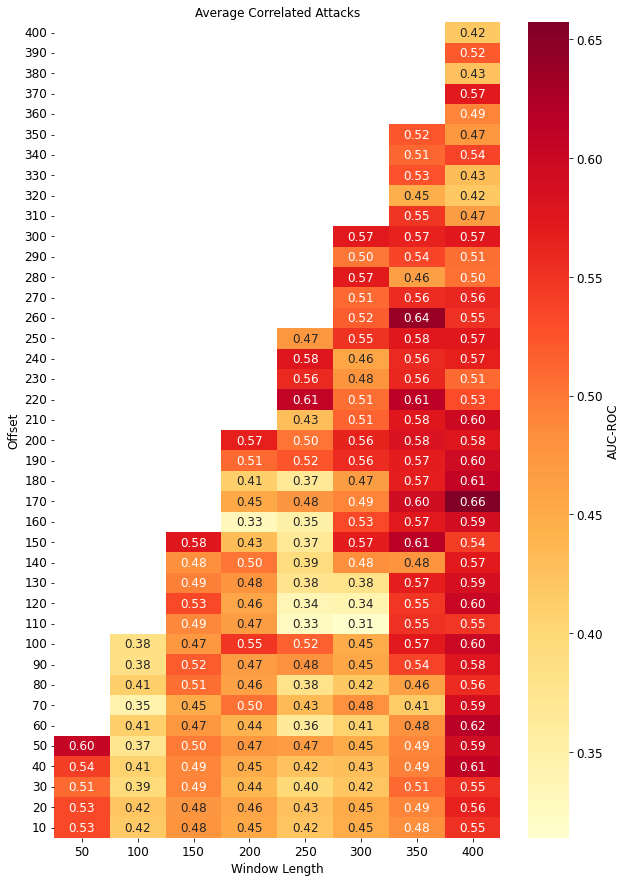

mean:  0.4963876829220551
std:  0.07281547478181992
median:  0.49884806551473215
min:  0.3137626262626263 ('110', '300')
max:  0.6571428571428571 ('170', '400') 



In [53]:
df_to_inspect = dfs_correlated
df_rocauc_avg = pd.DataFrame(np.array([df.to_numpy() for df in df_to_inspect]).mean(axis=0), index=df_to_inspect[0].index, columns=df_to_inspect[0].columns)
df_rocauc_avg.to_csv(f"../data/average_{method}_method_{attack}_attack.csv", sep=" ", header=True)

fig, ax = plt.subplots(figsize=(10, 15))

g = sns.heatmap(df_rocauc_avg, annot=True, cbar=True, cbar_kws={"label": "AUC-ROC", "location":"right", "pad":0.05, "format":"%.2f"}, 
    annot_kws={"size": 12}, fmt=".2f", ax=ax, cmap="YlOrRd")

ax.set_ylabel("Offset", fontsize=12)
ax.set_xlabel("Window Length", fontsize=12)
ax.set_title("Average Correlated Attacks", fontsize=12)

# colobar
cax = g.figure.axes[-1]
cax.yaxis.label.set_size(12)
cax.tick_params(labelsize=12)

# x-axis
g.set_xticklabels(g.get_xticklabels(), rotation=0, fontsize=12)

# y-axis
if g.get_yticklabels():
    g.set_yticklabels(g.get_yticklabels(), rotation=0, fontsize=12)


plt.show()

# Compute basic statistics about elements in the frame
print("mean: ", np.nanmean(df_rocauc_avg))
print("std: ", np.nanstd(df_rocauc_avg))
print("median: ", np.nanmedian(df_rocauc_avg))
print("min: ", np.nanmin(df_rocauc_avg), df_rocauc_avg.stack().idxmin())
print("max: ", np.nanmax(df_rocauc_avg), df_rocauc_avg.stack().idxmax(), "\n")

## Average Max Engine Attack

In [54]:
method = "DBSCAN"
attack = "max_engine"

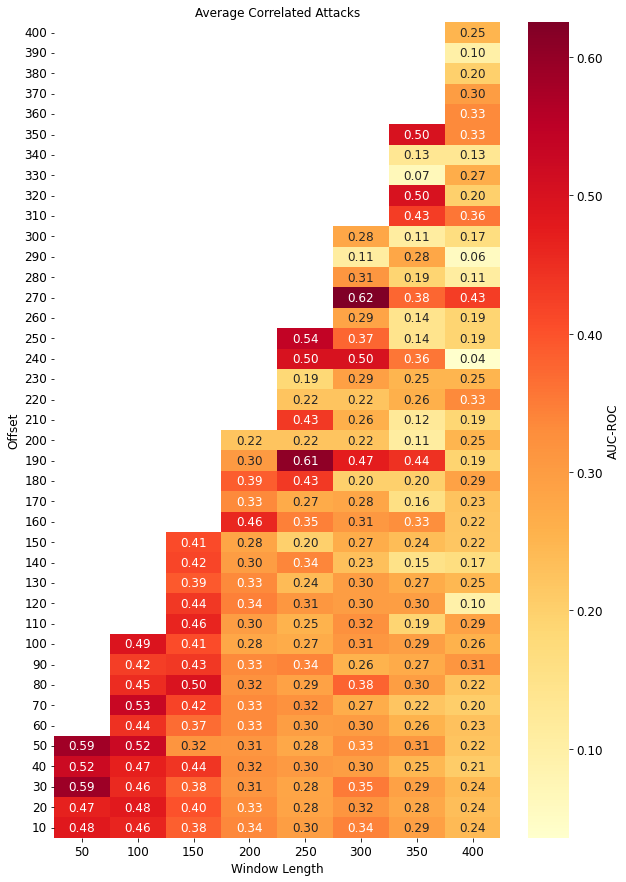

mean:  0.3077755988222105
std:  0.11343039181503867
median:  0.2979286939709166
min:  0.035714285714285726 ('240', '400')
max:  0.625 ('270', '300') 



In [55]:
df_to_inspect = dfs_max_engine
df_rocauc_avg = pd.DataFrame(np.array([df.to_numpy() for df in df_to_inspect]).mean(axis=0), index=df_to_inspect[0].index, columns=df_to_inspect[0].columns)
df_rocauc_avg.to_csv(f"../data/average_{method}_method_{attack}_attack.csv", sep=" ", header=True)

fig, ax = plt.subplots(figsize=(10, 15))

g = sns.heatmap(df_rocauc_avg, annot=True, cbar=True, cbar_kws={"label": "AUC-ROC", "location":"right", "pad":0.05, "format":"%.2f"}, 
    annot_kws={"size": 12}, fmt=".2f", ax=ax, cmap="YlOrRd")

ax.set_ylabel("Offset", fontsize=12)
ax.set_xlabel("Window Length", fontsize=12)
ax.set_title("Average Correlated Attacks", fontsize=12)

# colobar
cax = g.figure.axes[-1]
cax.yaxis.label.set_size(12)
cax.tick_params(labelsize=12)

# x-axis
g.set_xticklabels(g.get_xticklabels(), rotation=0, fontsize=12)

# y-axis
if g.get_yticklabels():
    g.set_yticklabels(g.get_yticklabels(), rotation=0, fontsize=12)

plt.show()

# Compute basic statistics about elements in the frame
print("mean: ", np.nanmean(df_rocauc_avg))
print("std: ", np.nanstd(df_rocauc_avg))
print("median: ", np.nanmedian(df_rocauc_avg))
print("min: ", np.nanmin(df_rocauc_avg), df_rocauc_avg.stack().idxmin())
print("max: ", np.nanmax(df_rocauc_avg), df_rocauc_avg.stack().idxmax(), "\n")

## Average Max Speedometer Attack

In [56]:
method = "DBSCAN"
attack = "max_speedometer"

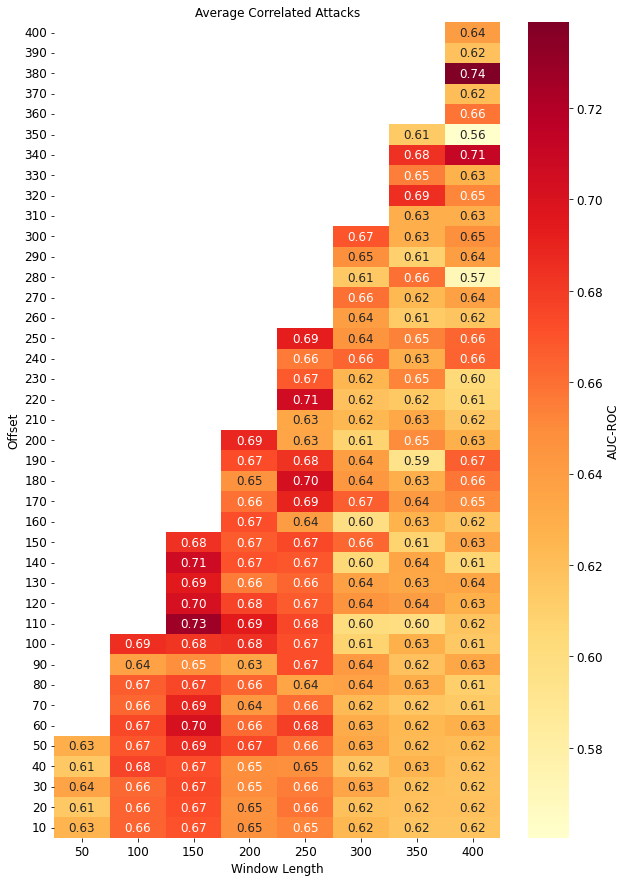

mean:  0.6459500231253283
std:  0.02911600470310433
median:  0.6424527082537919
min:  0.5602861319966583 ('350', '400')
max:  0.7387177093059446 ('380', '400') 



In [57]:
df_to_inspect = dfs_max_speedometer
df_rocauc_avg = pd.DataFrame(np.array([df.to_numpy() for df in df_to_inspect]).mean(axis=0), index=df_to_inspect[0].index, columns=df_to_inspect[0].columns)
df_rocauc_avg.to_csv(f"../data/average_{method}_method_{attack}_attack.csv", sep=" ", header=True)

fig, ax = plt.subplots(figsize=(10, 15))

g = sns.heatmap(df_rocauc_avg, annot=True, cbar=True, cbar_kws={"label": "AUC-ROC", "location":"right", "pad":0.05, "format":"%.2f"}, 
    annot_kws={"size": 12}, fmt=".2f", ax=ax, cmap="YlOrRd")

ax.set_ylabel("Offset", fontsize=12)
ax.set_xlabel("Window Length", fontsize=12)
ax.set_title("Average Correlated Attacks", fontsize=12)

# colobar
cax = g.figure.axes[-1]
cax.yaxis.label.set_size(12)
cax.tick_params(labelsize=12)

# x-axis
g.set_xticklabels(g.get_xticklabels(), rotation=0, fontsize=12)

# y-axis
if g.get_yticklabels():
    g.set_yticklabels(g.get_yticklabels(), rotation=0, fontsize=12)

plt.show()

# Compute basic statistics about elements in the frame
print("mean: ", np.nanmean(df_rocauc_avg))
print("std: ", np.nanstd(df_rocauc_avg))
print("median: ", np.nanmedian(df_rocauc_avg))
print("min: ", np.nanmin(df_rocauc_avg), df_rocauc_avg.stack().idxmin())
print("max: ", np.nanmax(df_rocauc_avg), df_rocauc_avg.stack().idxmax(), "\n")

## Average Reverse Light Off Attack

In [58]:
method = "DBSCAN"
attack = "light_off"

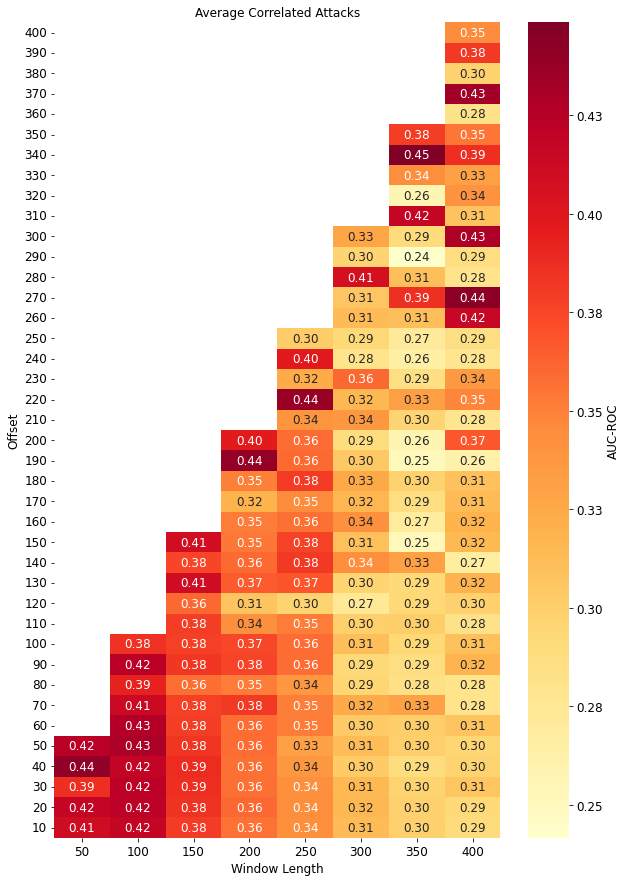

mean:  0.33862617239216236
std:  0.04820900237414889
median:  0.3371286121286121
min:  0.24166666666666667 ('290', '350')
max:  0.448559670781893 ('340', '350') 



In [59]:
df_to_inspect = dfs_rev_light_off
df_rocauc_avg = pd.DataFrame(np.array([df.to_numpy() for df in df_to_inspect]).mean(axis=0), index=df_to_inspect[0].index, columns=df_to_inspect[0].columns)
df_rocauc_avg.to_csv(f"../data/average_{method}_method_{attack}_attack.csv", sep=" ", header=True)

fig, ax = plt.subplots(figsize=(10, 15))

g = sns.heatmap(df_rocauc_avg, annot=True, cbar=True, cbar_kws={"label": "AUC-ROC", "location":"right", "pad":0.05, "format":"%.2f"}, 
    annot_kws={"size": 12}, fmt=".2f", ax=ax, cmap="YlOrRd")

ax.set_ylabel("Offset", fontsize=12)
ax.set_xlabel("Window Length", fontsize=12)
ax.set_title("Average Correlated Attacks", fontsize=12)

# colobar
cax = g.figure.axes[-1]
cax.yaxis.label.set_size(12)
cax.tick_params(labelsize=12)

# x-axis
g.set_xticklabels(g.get_xticklabels(), rotation=0, fontsize=12)

# y-axis
if g.get_yticklabels():
    g.set_yticklabels(g.get_yticklabels(), rotation=0, fontsize=12)

plt.show()

# Compute basic statistics about elements in the frame
print("mean: ", np.nanmean(df_rocauc_avg))
print("std: ", np.nanstd(df_rocauc_avg))
print("median: ", np.nanmedian(df_rocauc_avg))
print("min: ", np.nanmin(df_rocauc_avg), df_rocauc_avg.stack().idxmin())
print("max: ", np.nanmax(df_rocauc_avg), df_rocauc_avg.stack().idxmax(), "\n")

## Average Reverse Light On Attack

In [60]:
method = "DBSCAN"
attack = "light_on"

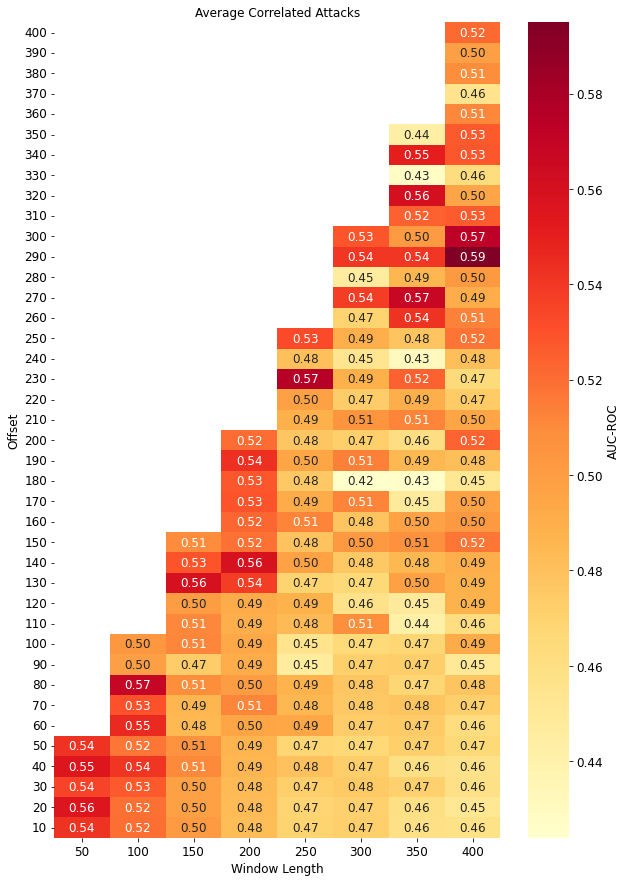

mean:  0.4946746860264864
std:  0.03182390203774273
median:  0.49031034037144583
min:  0.4239306445188798 ('180', '300')
max:  0.59491341991342 ('290', '400') 



In [61]:
df_to_inspect = dfs_rev_light_on
df_rocauc_avg = pd.DataFrame(np.array([df.to_numpy() for df in df_to_inspect]).mean(axis=0), index=df_to_inspect[0].index, columns=df_to_inspect[0].columns)
df_rocauc_avg.to_csv(f"../data/average_{method}_method_{attack}_attack.csv", sep=" ", header=True)

fig, ax = plt.subplots(figsize=(10, 15))

g = sns.heatmap(df_rocauc_avg, annot=True, cbar=True, cbar_kws={"label": "AUC-ROC", "location":"right", "pad":0.05, "format":"%.2f"}, 
    annot_kws={"size": 12}, fmt=".2f", ax=ax, cmap="YlOrRd")

ax.set_ylabel("Offset", fontsize=12)
ax.set_xlabel("Window Length", fontsize=12)
ax.set_title("Average Correlated Attacks", fontsize=12)

# colobar
cax = g.figure.axes[-1]
cax.yaxis.label.set_size(12)
cax.tick_params(labelsize=12)

# x-axis
g.set_xticklabels(g.get_xticklabels(), rotation=0, fontsize=12)

# y-axis
if g.get_yticklabels():
    g.set_yticklabels(g.get_yticklabels(), rotation=0, fontsize=12)

plt.show()

# Compute basic statistics about elements in the frame
print("mean: ", np.nanmean(df_rocauc_avg))
print("std: ", np.nanstd(df_rocauc_avg))
print("median: ", np.nanmedian(df_rocauc_avg))
print("min: ", np.nanmin(df_rocauc_avg), df_rocauc_avg.stack().idxmin())
print("max: ", np.nanmax(df_rocauc_avg), df_rocauc_avg.stack().idxmax(), "\n")

# Single Figure DBSCAN

In [62]:
files = []

for file in os.listdir("../data/"):
    if file.startswith("average_DBSCAN_"):
        # if file.endswith("_distribution_ROAD.json"):
        files.append(file) # print(file)
        
files = sorted(files)
# print(files)
files = [files[0], files[3], files[4], files[1], files[2]] 
print(files)

['average_DBSCAN_method_correlated_attack.csv', 'average_DBSCAN_method_max_engine_attack.csv', 'average_DBSCAN_method_max_speedometer_attack.csv', 'average_DBSCAN_method_light_off_attack.csv', 'average_DBSCAN_method_light_on_attack.csv']


0 average_DBSCAN_method_correlated_attack.csv
1 average_DBSCAN_method_max_engine_attack.csv
2 average_DBSCAN_method_max_speedometer_attack.csv
3 average_DBSCAN_method_light_off_attack.csv
4 average_DBSCAN_method_light_on_attack.csv


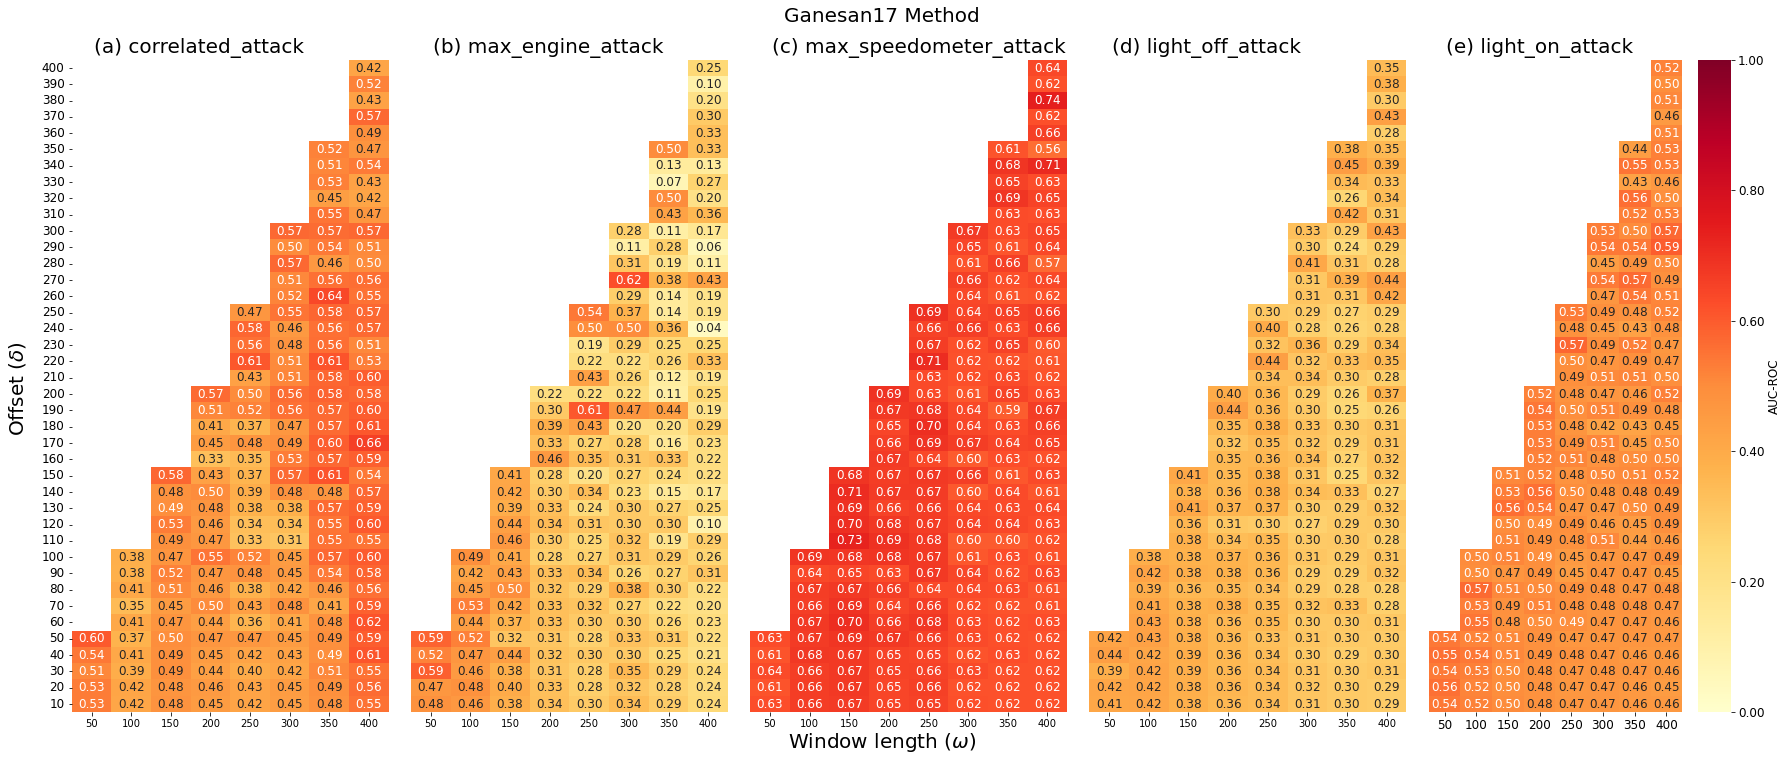

In [64]:
metrics = ["", "", "", "", ""]
coordinates = [[0, 0], [0, 1], [0, 2], [0, 3], [0, 4]]

fig, axes = plt.subplots(1, 5, figsize=(30, 12), sharex=True, sharey=True, gridspec_kw = {"wspace":0.07, "hspace":0.1}) # figsize=(30, 14)

# Set common labels

# axes.set_xlabel('common xlabel')
# axes.set_ylabel('common ylabel')
# fig.suptitle("Correlation Method", size=12)

for index, file in enumerate(files): 
    print(index, file)

    df = pd.read_csv("../data/" + file, sep=" ", index_col=0) # display(df)

    # display(f"mean: {df.stack().dropna().mean()}, std: {df.stack().dropna(). ↪std()}, median: {df.stack().dropna().median()}")
    ax = index

    if index == 4:
        g = sns.heatmap(df, vmin=0.0, vmax=1.0, annot=True, cbar=True, cbar_kws={"label": "AUC-ROC", "location":"right", "pad":0.05, "format":"%.2f"}, 
            annot_kws={"size": 12}, fmt=".2f", ax=axes[index], cmap="YlOrRd")
        
        # g = sns.heatmap(df, vmin=0.0, vmax=1.0, annot=True, cbar=True, cbar_kws={"label": metrics[index], "location":"top", "pad":0.05, "format":"%.2f"}, annot_kws={"size": 12}, fmt=".2f", ax=axes[index], cmap="YlOrRd")
        
    else:
        g = sns.heatmap(df, vmin=0.0, vmax=1.0, annot=True, cbar=False, annot_kws={"size": 12}, fmt=".2f", ax=axes[index], cmap="YlOrRd")

    
    # text annotation
    annotation = file.split("method")
    axes[index].text(0.07, 1.01, "(" + string.ascii_lowercase[index] + ")" + " " + annotation[1][1:-4], transform=axes[index].transAxes, size=20)
    
    # print(annotation)
    # print(annotation[1][1:-4])

    # colobar
    cax = g.figure.axes[-1]
    cax.yaxis.label.set_size(12)
    cax.tick_params(labelsize=12)
    
    # # x-axis
    # g.set_xticklabels(g.get_xticklabels(), rotation=90, fontsize=12)
    
    # # y-axis
    if g.get_yticklabels(): 
        g.set_yticklabels(g.get_yticklabels(), fontsize=12)

    if index > 0: 
         axes[index].tick_params(left=False)


# Set common labels
fig.text(0.5, 0.09, "Window length ($\omega$)", ha="center", va="center", fontsize=20)
fig.text(0.1, 0.50, "Offset ($\delta$)", ha="center", va="center", rotation="vertical", fontsize=20) # 0.1, 0.45
fig.text(0.5, 0.93, "Ganesan17 Method", ha="center", va="center", fontsize=20)

plt.savefig("../figs/" + "DBSCAN_all_fig.pdf", dpi=200, bbox_inches="tight")
plt.show()

## All Attack Files by AHC Method

In [65]:
files = []

for file in os.listdir("../data/"):
    if file.startswith("results_"):
        if file.endswith("_AHC_ROAD.json"):
            files.append(file)

print(len(files), files)
# files = [files[0], files[1], files[2], files[3]]
# print(files)

13 ['results_reverse_light_off_attack_1_masquerade_AHC_ROAD.json', 'results_correlated_signal_attack_2_masquerade_AHC_ROAD.json', 'results_reverse_light_off_attack_3_masquerade_AHC_ROAD.json', 'results_max_engine_coolant_temp_attack_masquerade_AHC_ROAD.json', 'results_max_speedometer_attack_1_masquerade_AHC_ROAD.json', 'results_max_speedometer_attack_3_masquerade_AHC_ROAD.json', 'results_reverse_light_on_attack_2_masquerade_AHC_ROAD.json', 'results_correlated_signal_attack_3_masquerade_AHC_ROAD.json', 'results_reverse_light_on_attack_3_masquerade_AHC_ROAD.json', 'results_reverse_light_on_attack_1_masquerade_AHC_ROAD.json', 'results_correlated_signal_attack_1_masquerade_AHC_ROAD.json', 'results_reverse_light_off_attack_2_masquerade_AHC_ROAD.json', 'results_max_speedometer_attack_2_masquerade_AHC_ROAD.json']


## Filtering Files Per Attacks File

In [66]:
# metrics = ["DR", "FAR", "AUC-ROC", "AUC-PR"]
# coordinates = [[0, 0], [0, 1], [1, 0], [1, 1]]

# fig, axes = plt.subplots(2, 2, figsize=(25, 14), sharex=True, sharey=True, gridspec_kw = {"wspace":-0.02, "hspace":0.1})
# fig.suptitle("Logistic Regression", size=12)

dfs_correlated = []
dfs_max_engine = []
dfs_max_speedometer = []
dfs_rev_light_off = []
dfs_rev_light_on = []

for index, file in enumerate(files):

    print(file)

    with open(f"/home/cloud/ceph-robust/CAN/signal-ids-benchmark/data/{file}", "r") as outfile:
        grid2performance = json.load(outfile)


    key2aucroc = defaultdict(list)
    index = []

    for key in grid2performance.keys():

        ground_truth = grid2performance[key]["ground_truth"]
        predict_proba = grid2performance[key]["predict_proba"]

        columns = key.split("-")

        # print(columns)
        key2aucroc[columns[0]].append(roc_auc_score(ground_truth, predict_proba))
        # sample.append(dict(entry))

        if columns[1] not in index: 
            index.append(columns[1])

    key2aucroc = dict(key2aucroc)
    # print(key2aucroc)
    # print(len(index), index)

    df_rocauc = pd.DataFrame({k:pd.Series(v) for k, v in key2aucroc.items()})
    df_rocauc.index = index
    df_rocauc = df_rocauc[::-1] # invert the order of dataframe rows


    if "correlated" in file:
        dfs_correlated.append(df_rocauc)

    if "max_engine" in file:
        dfs_max_engine.append(df_rocauc)

    if "speedometer" in file:
        dfs_max_speedometer.append(df_rocauc)

    if "reverse_light_off" in file:
        dfs_rev_light_off.append(df_rocauc)

    if "reverse_light_on" in file:
        dfs_rev_light_on.append(df_rocauc)

results_reverse_light_off_attack_1_masquerade_AHC_ROAD.json
results_correlated_signal_attack_2_masquerade_AHC_ROAD.json
results_reverse_light_off_attack_3_masquerade_AHC_ROAD.json
results_max_engine_coolant_temp_attack_masquerade_AHC_ROAD.json
results_max_speedometer_attack_1_masquerade_AHC_ROAD.json
results_max_speedometer_attack_3_masquerade_AHC_ROAD.json
results_reverse_light_on_attack_2_masquerade_AHC_ROAD.json
results_correlated_signal_attack_3_masquerade_AHC_ROAD.json
results_reverse_light_on_attack_3_masquerade_AHC_ROAD.json
results_reverse_light_on_attack_1_masquerade_AHC_ROAD.json
results_correlated_signal_attack_1_masquerade_AHC_ROAD.json
results_reverse_light_off_attack_2_masquerade_AHC_ROAD.json
results_max_speedometer_attack_2_masquerade_AHC_ROAD.json


## Average Correlated Attack

In [67]:
method = "AHC"
attack = "correlated"

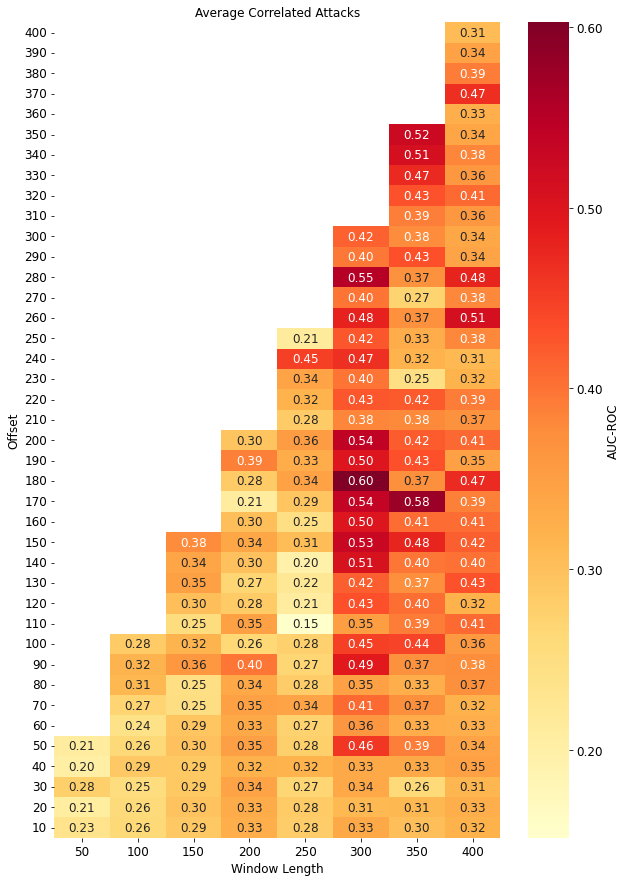

mean:  0.3527363435488942
std:  0.08098979616174508
median:  0.34307778641111975
min:  0.1513024013024013 ('110', '250')
max:  0.6025641025641025 ('180', '300') 



In [68]:
df_to_inspect = dfs_correlated
df_rocauc_avg = pd.DataFrame(np.array([df.to_numpy() for df in df_to_inspect]).mean(axis=0), index=df_to_inspect[0].index, columns=df_to_inspect[0].columns)
df_rocauc_avg.to_csv(f"../data/average_{method}_method_{attack}_attack.csv", sep=" ", header=True)

fig, ax = plt.subplots(figsize=(10, 15))

g = sns.heatmap(df_rocauc_avg, annot=True, cbar=True, cbar_kws={"label": "AUC-ROC", "location":"right", "pad":0.05, "format":"%.2f"}, 
    annot_kws={"size": 12}, fmt=".2f", ax=ax, cmap="YlOrRd")

ax.set_ylabel("Offset", fontsize=12)
ax.set_xlabel("Window Length", fontsize=12)
ax.set_title("Average Correlated Attacks", fontsize=12)

# colobar
cax = g.figure.axes[-1]
cax.yaxis.label.set_size(12)
cax.tick_params(labelsize=12)

# x-axis
g.set_xticklabels(g.get_xticklabels(), rotation=0, fontsize=12)

# y-axis
if g.get_yticklabels():
    g.set_yticklabels(g.get_yticklabels(), rotation=0, fontsize=12)

plt.show()

# Compute basic statistics about elements in the frame
print("mean: ", np.nanmean(df_rocauc_avg))
print("std: ", np.nanstd(df_rocauc_avg))
print("median: ", np.nanmedian(df_rocauc_avg))
print("min: ", np.nanmin(df_rocauc_avg), df_rocauc_avg.stack().idxmin())
print("max: ", np.nanmax(df_rocauc_avg), df_rocauc_avg.stack().idxmax(), "\n")

## Average Max Engine Attack

In [69]:
method = "AHC"
attack = "max_engine"

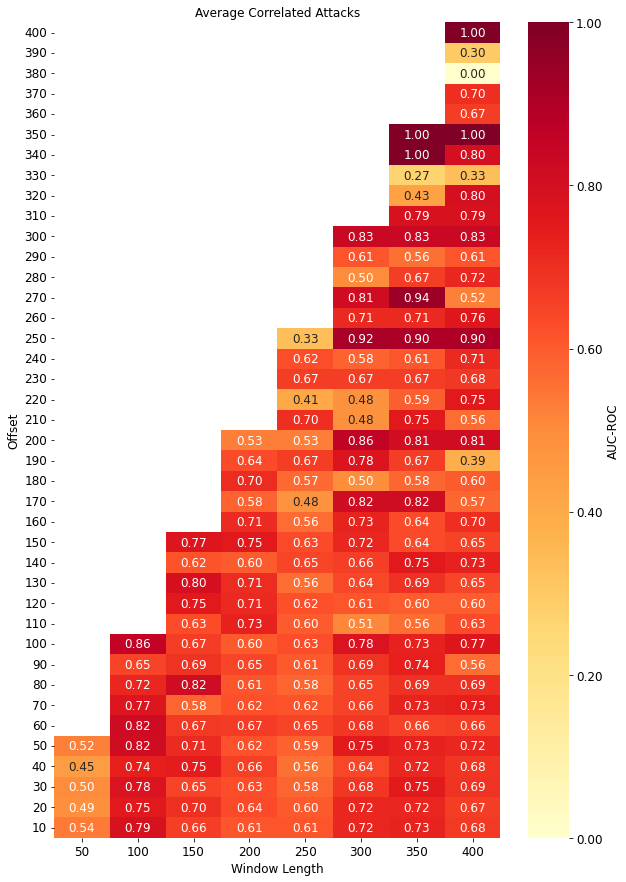

mean:  0.6662539922597379
std:  0.13211423478385048
median:  0.6666666666666666
min:  0.0 ('380', '400')
max:  1.0 ('400', '400') 



In [70]:
df_to_inspect = dfs_max_engine
df_rocauc_avg = pd.DataFrame(np.array([df.to_numpy() for df in df_to_inspect]).mean(axis=0), index=df_to_inspect[0].index, columns=df_to_inspect[0].columns)
df_rocauc_avg.to_csv(f"../data/average_{method}_method_{attack}_attack.csv", sep=" ", header=True)

fig, ax = plt.subplots(figsize=(10, 15))

g = sns.heatmap(df_rocauc_avg, annot=True, cbar=True, cbar_kws={"label": "AUC-ROC", "location":"right", "pad":0.05, "format":"%.2f"}, 
    annot_kws={"size": 12}, fmt=".2f", ax=ax, cmap="YlOrRd")

ax.set_ylabel("Offset", fontsize=12)
ax.set_xlabel("Window Length", fontsize=12)
ax.set_title("Average Correlated Attacks", fontsize=12)

# colobar
cax = g.figure.axes[-1]
cax.yaxis.label.set_size(12)
cax.tick_params(labelsize=12)

# x-axis
g.set_xticklabels(g.get_xticklabels(), rotation=0, fontsize=12)

# y-axis
if g.get_yticklabels():
    g.set_yticklabels(g.get_yticklabels(), rotation=0, fontsize=12)

plt.show()

# Compute basic statistics about elements in the frame
print("mean: ", np.nanmean(df_rocauc_avg))
print("std: ", np.nanstd(df_rocauc_avg))
print("median: ", np.nanmedian(df_rocauc_avg))
print("min: ", np.nanmin(df_rocauc_avg), df_rocauc_avg.stack().idxmin())
print("max: ", np.nanmax(df_rocauc_avg), df_rocauc_avg.stack().idxmax(), "\n")

## Average Max Speedometer Attack

In [71]:
method = "AHC"
attack = "max_speedometer"

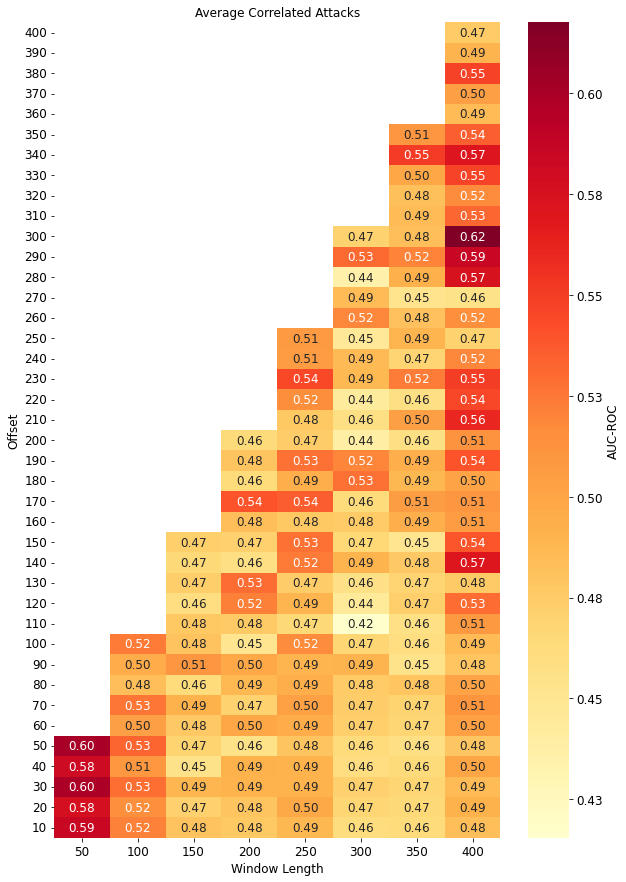

mean:  0.49486139700830994
std:  0.03466646072929821
median:  0.48785673120610373
min:  0.41547506445878435 ('110', '300')
max:  0.6175613275613275 ('300', '400') 



In [72]:
df_to_inspect = dfs_max_speedometer
df_rocauc_avg = pd.DataFrame(np.array([df.to_numpy() for df in df_to_inspect]).mean(axis=0), index=df_to_inspect[0].index, columns=df_to_inspect[0].columns)
df_rocauc_avg.to_csv(f"../data/average_{method}_method_{attack}_attack.csv", sep=" ", header=True)

fig, ax = plt.subplots(figsize=(10, 15))

g = sns.heatmap(df_rocauc_avg, annot=True, cbar=True, cbar_kws={"label": "AUC-ROC", "location":"right", "pad":0.05, "format":"%.2f"}, 
    annot_kws={"size": 12}, fmt=".2f", ax=ax, cmap="YlOrRd")

ax.set_ylabel("Offset", fontsize=12)
ax.set_xlabel("Window Length", fontsize=12)
ax.set_title("Average Correlated Attacks", fontsize=12)

# colobar
cax = g.figure.axes[-1]
cax.yaxis.label.set_size(12)
cax.tick_params(labelsize=12)

# x-axis
g.set_xticklabels(g.get_xticklabels(), rotation=0, fontsize=12)

# y-axis
if g.get_yticklabels():
    g.set_yticklabels(g.get_yticklabels(), rotation=0, fontsize=12)

plt.show()

# Compute basic statistics about elements in the frame
print("mean: ", np.nanmean(df_rocauc_avg))
print("std: ", np.nanstd(df_rocauc_avg))
print("median: ", np.nanmedian(df_rocauc_avg))
print("min: ", np.nanmin(df_rocauc_avg), df_rocauc_avg.stack().idxmin())
print("max: ", np.nanmax(df_rocauc_avg), df_rocauc_avg.stack().idxmax(), "\n")

## Average Reverse Light Off Attack

In [73]:
method = "AHC"
attack = "light_off"

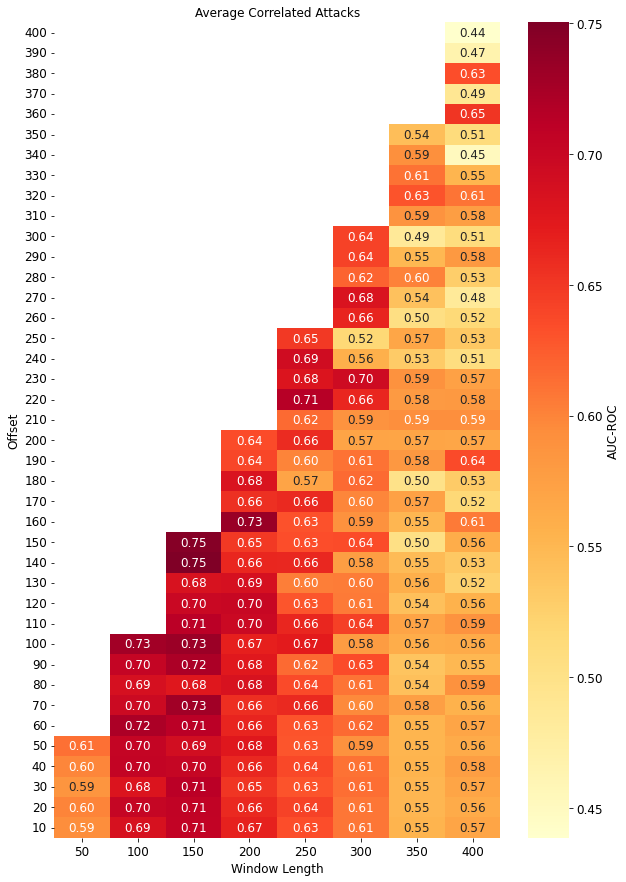

mean:  0.6119869020031135
std:  0.06547273157723138
median:  0.6086814820931514
min:  0.43849206349206343 ('400', '400')
max:  0.7503757380568975 ('140', '150') 



In [74]:
df_to_inspect = dfs_rev_light_off
df_rocauc_avg = pd.DataFrame(np.array([df.to_numpy() for df in df_to_inspect]).mean(axis=0), index=df_to_inspect[0].index, columns=df_to_inspect[0].columns)
df_rocauc_avg.to_csv(f"../data/average_{method}_method_{attack}_attack.csv", sep=" ", header=True)

fig, ax = plt.subplots(figsize=(10, 15))

g = sns.heatmap(df_rocauc_avg, annot=True, cbar=True, cbar_kws={"label": "AUC-ROC", "location":"right", "pad":0.05, "format":"%.2f"}, 
    annot_kws={"size": 12}, fmt=".2f", ax=ax, cmap="YlOrRd")

ax.set_ylabel("Offset", fontsize=12)
ax.set_xlabel("Window Length", fontsize=12)
ax.set_title("Average Correlated Attacks", fontsize=12)

# colobar
cax = g.figure.axes[-1]
cax.yaxis.label.set_size(12)
cax.tick_params(labelsize=12)

# x-axis
g.set_xticklabels(g.get_xticklabels(), rotation=0, fontsize=12)

# y-axis
if g.get_yticklabels():
    g.set_yticklabels(g.get_yticklabels(), rotation=0, fontsize=12)

plt.show()

# Compute basic statistics about elements in the frame
print("mean: ", np.nanmean(df_rocauc_avg))
print("std: ", np.nanstd(df_rocauc_avg))
print("median: ", np.nanmedian(df_rocauc_avg))
print("min: ", np.nanmin(df_rocauc_avg), df_rocauc_avg.stack().idxmin())
print("max: ", np.nanmax(df_rocauc_avg), df_rocauc_avg.stack().idxmax(), "\n")


## Average Reverse Light On Attack

In [75]:
method = "AHC"
attack = "light_on"

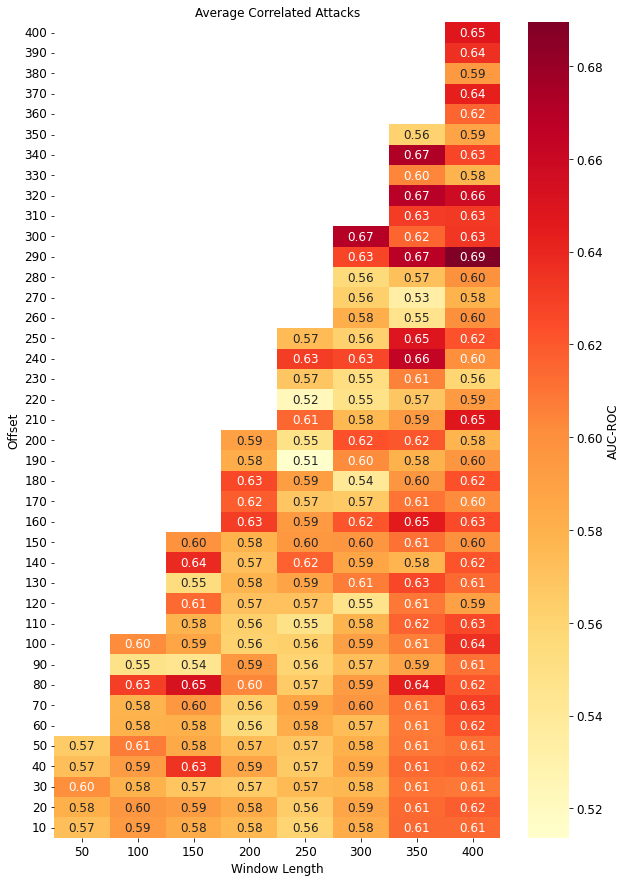

mean:  0.5958869494185021
std:  0.030631466568051144
median:  0.5936820425017019
min:  0.51368139848532 ('190', '250')
max:  0.6893939393939393 ('290', '400') 



In [76]:
df_to_inspect = dfs_rev_light_on
df_rocauc_avg = pd.DataFrame(np.array([df.to_numpy() for df in df_to_inspect]).mean(axis=0), index=df_to_inspect[0].index, columns=df_to_inspect[0].columns)
df_rocauc_avg.to_csv(f"../data/average_{method}_method_{attack}_attack.csv", sep=" ", header=True)

fig, ax = plt.subplots(figsize=(10, 15))

g = sns.heatmap(df_rocauc_avg, annot=True, cbar=True, cbar_kws={"label": "AUC-ROC", "location":"right", "pad":0.05, "format":"%.2f"}, 
    annot_kws={"size": 12}, fmt=".2f", ax=ax, cmap="YlOrRd")

ax.set_ylabel("Offset", fontsize=12)
ax.set_xlabel("Window Length", fontsize=12)
ax.set_title("Average Correlated Attacks", fontsize=12)

# colobar
cax = g.figure.axes[-1]
cax.yaxis.label.set_size(12)
cax.tick_params(labelsize=12)

# x-axis
g.set_xticklabels(g.get_xticklabels(), rotation=0, fontsize=12)

# y-axis
if g.get_yticklabels():
    g.set_yticklabels(g.get_yticklabels(), rotation=0, fontsize=12)

plt.show()

# Compute basic statistics about elements in the frame
print("mean: ", np.nanmean(df_rocauc_avg))
print("std: ", np.nanstd(df_rocauc_avg))
print("median: ", np.nanmedian(df_rocauc_avg))
print("min: ", np.nanmin(df_rocauc_avg), df_rocauc_avg.stack().idxmin())
print("max: ", np.nanmax(df_rocauc_avg), df_rocauc_avg.stack().idxmax(), "\n")

## Single Figure AHC

In [77]:
files = []

for file in os.listdir("../data/"):
    if file.startswith("average_AHC_"):
        # if file.endswith("_distribution_ROAD.json"):
        files.append(file) # print(file)

files = sorted(files)
print(files)

files = [files[0], files[3], files[4], files[1], files[2]]
print(files)

['average_AHC_method_correlated_attack.csv', 'average_AHC_method_light_off_attack.csv', 'average_AHC_method_light_on_attack.csv', 'average_AHC_method_max_engine_attack.csv', 'average_AHC_method_max_speedometer_attack.csv']
['average_AHC_method_correlated_attack.csv', 'average_AHC_method_max_engine_attack.csv', 'average_AHC_method_max_speedometer_attack.csv', 'average_AHC_method_light_off_attack.csv', 'average_AHC_method_light_on_attack.csv']


0 average_AHC_method_correlated_attack.csv
1 average_AHC_method_max_engine_attack.csv
2 average_AHC_method_max_speedometer_attack.csv


3 average_AHC_method_light_off_attack.csv
4 average_AHC_method_light_on_attack.csv


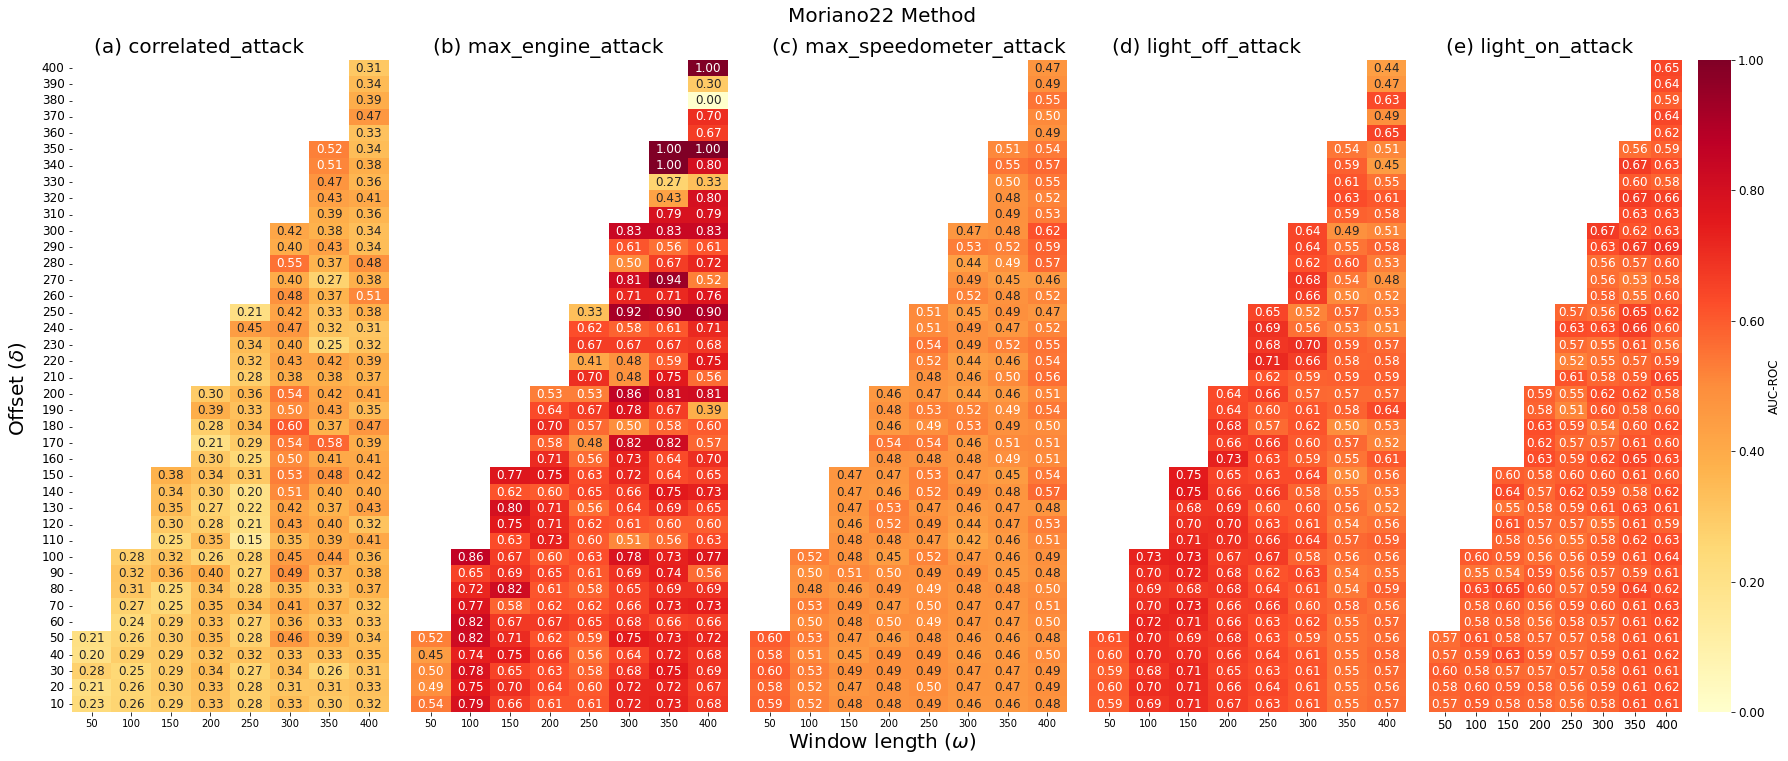

In [79]:
metrics = ["", "", "", "", ""]
coordinates = [[0, 0], [0, 1], [0, 2], [0, 3], [0, 4]]

fig, axes = plt.subplots(1, 5, figsize=(30, 12), sharex=True, sharey=True, gridspec_kw = {"wspace":0.07, "hspace":0.1}) # figsize=(30, 14)

# Set common labels

# axes.set_xlabel('common xlabel')
# axes.set_ylabel('common ylabel')
# fig.suptitle("Correlation Method", size=12)

for index, file in enumerate(files): 
    print(index, file)

    df = pd.read_csv("../data/" + file, sep=" ", index_col=0) # display(df)

    # display(f"mean: {df.stack().dropna().mean()}, std: {df.stack().dropna(). ↪std()}, median: {df.stack().dropna().median()}")
    ax = index

    if index == 4:
        g = sns.heatmap(df, vmin=0.0, vmax=1.0, annot=True, cbar=True, cbar_kws={"label": "AUC-ROC", "location":"right", "pad":0.05, "format":"%.2f"}, 
            annot_kws={"size": 12}, fmt=".2f", ax=axes[index], cmap="YlOrRd")
        
        # g = sns.heatmap(df, vmin=0.0, vmax=1.0, annot=True, cbar=True, cbar_kws={"label": metrics[index], "location":"top", "pad":0.05, "format":"%.2f"}, annot_kws={"size": 12}, fmt=".2f", ax=axes[index], cmap="YlOrRd")
        
    else:
        g = sns.heatmap(df, vmin=0.0, vmax=1.0, annot=True, cbar=False, annot_kws={"size": 12}, fmt=".2f", ax=axes[index], cmap="YlOrRd")
    
    # text annotation
    annotation = file.split("method")
    axes[index].text(0.07, 1.01, "(" + string.ascii_lowercase[index] + ")" + " " + annotation[1][1:-4], transform=axes[index].transAxes, size=20)
    
    # print(annotation)
    # print(annotation[1][1:-4])

    # colobar
    cax = g.figure.axes[-1]
    cax.yaxis.label.set_size(12)
    cax.tick_params(labelsize=12)
    
    # # x-axis
    # g.set_xticklabels(g.get_xticklabels(), rotation=90, fontsize=12)
    
    # # y-axis
    if g.get_yticklabels(): 
        g.set_yticklabels(g.get_yticklabels(), fontsize=12)

    if index > 0: 
         axes[index].tick_params(left=False)


# Set common labels
fig.text(0.5, 0.09, "Window length ($\omega$)", ha="center", va="center", fontsize=20)
fig.text(0.1, 0.50, "Offset ($\delta$)", ha="center", va="center", rotation="vertical", fontsize=20) # 0.1, 0.45
fig.text(0.5, 0.93, "Moriano22 Method", ha="center", va="center", fontsize=20)

plt.savefig("../figs/" + "AHC_all_fig.pdf", dpi=200, bbox_inches="tight")
plt.show()
